In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

# Sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Interpretability
try:
    import shap
    SHAP_AVAILABLE = True
except:
    SHAP_AVAILABLE = False
    print("⚠️  SHAP not available. Install: pip install shap")

try:
    import lime
    import lime.lime_tabular
    LIME_AVAILABLE = True
except:
    LIME_AVAILABLE = False
    print("⚠️  LIME not available. Install: pip install lime")

# Boosting
try:
    import xgboost as xgb; XGB = True
except:
    XGB = False
try:
    import lightgbm as lgb; LGB = True
except:
    LGB = False
try:
    from catboost import CatBoostRegressor; CB = True
except:
    CB = False

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Interpretability Tools:")
print(f"  SHAP: {'✓' if SHAP_AVAILABLE else '✗ (pip install shap)'}")
print(f"  LIME: {'✓' if LIME_AVAILABLE else '✗ (pip install lime)'}")
print(f"\nBoosting Libraries:")
print(f"  XGBoost: {'✓' if XGB else '✗'}")
print(f"  LightGBM: {'✓' if LGB else '✗'}")
print(f"  CatBoost: {'✓' if CB else '✗'}")

Interpretability Tools:
  SHAP: ✓
  LIME: ✓

Boosting Libraries:
  XGBoost: ✓
  LightGBM: ✓
  CatBoost: ✓


In [5]:
try:
    !pip install lime -qq
    print("✅ LIME installed successfully.")
except Exception as e:
    print(f"⚠️  Failed to install LIME: {e}")

try:
    !pip install catboost -qq
    print("✅ CatBoost installed successfully.")
except Exception as e:
    print(f"⚠️  Failed to install CatBoost: {e}")

✅ LIME installed successfully.
✅ CatBoost installed successfully.


In [6]:
# Load full dataset
df_full = pd.read_csv('/content/knitting_dataset.csv', encoding='latin1')
print(f"Total samples: {len(df_full):,}")

# Filter S/J only
df = df_full[df_full['construction'] == 'S/J'].copy()
print(f"S/J samples: {len(df):,} ({len(df)/len(df_full)*100:.1f}%)")

df.head()

Total samples: 12,569
S/J samples: 5,648 (44.9%)


M/C Brand Production Date M/C Dia & Gauge Booking Type  \
5   Fukuhara    01-06-2022           32 X 24         Main   
7   Fukuhara    01-06-2022           32 X 24         Main   
8   Fukuhara    01-06-2022           32 X 24         Main   
9   Fukuhara    01-06-2022           34 X 24         Main   
22  Fukuhara    01-06-2022           28 X 24         Main   

                                                Lot       Color  \
5                                    GU-L1811132018  09 BLACK     
7                                    GU-L1811132018  09 BLACK     
8                                           GU-667W  00 WHITE     
9                                    MS-L2811130034  HOT PINK     
22  MS-22-08148,MS-22-09035,MS-22-12330,MS-22-12331        YD     

      Color Range  stitch Dia  GSM  ...  yarn_count_tex_1  yarn_count_tex_2  \
5   Black Color    2.90    66  140  ...         18.456250               NaN   
7   Black Color    2.90    66  140  ...         18.456250               NaN   
8   White Color    2.95    66  140  ...         19.686667               NaN   
9   Light Color    2.85    70  140  ...         19.686667               NaN   
22         Wash    2.88    60  140  ...         19.686667               NaN   

    yarn_count_tex_3  stitch_1  stitch_2  stitch_3 tightness_factor  \
5                NaN      2.90       NaN       NaN         1.481405   
7                NaN      2.90       NaN       NaN         1.481405   
8                NaN      2.95       NaN       NaN         1.504056   
9                NaN      2.85       NaN       NaN         1.556830   
22               NaN      2.88       NaN       NaN         1.540613   

   composition  construction  body_part  
5       Cotton           S/J       Body  
7       Cotton           S/J       Body  
8       Cotton           S/J       Body  
9       Cotton           S/J        Top  
22      Cotton           S/J        Top  

[5 rows x 38 columns]

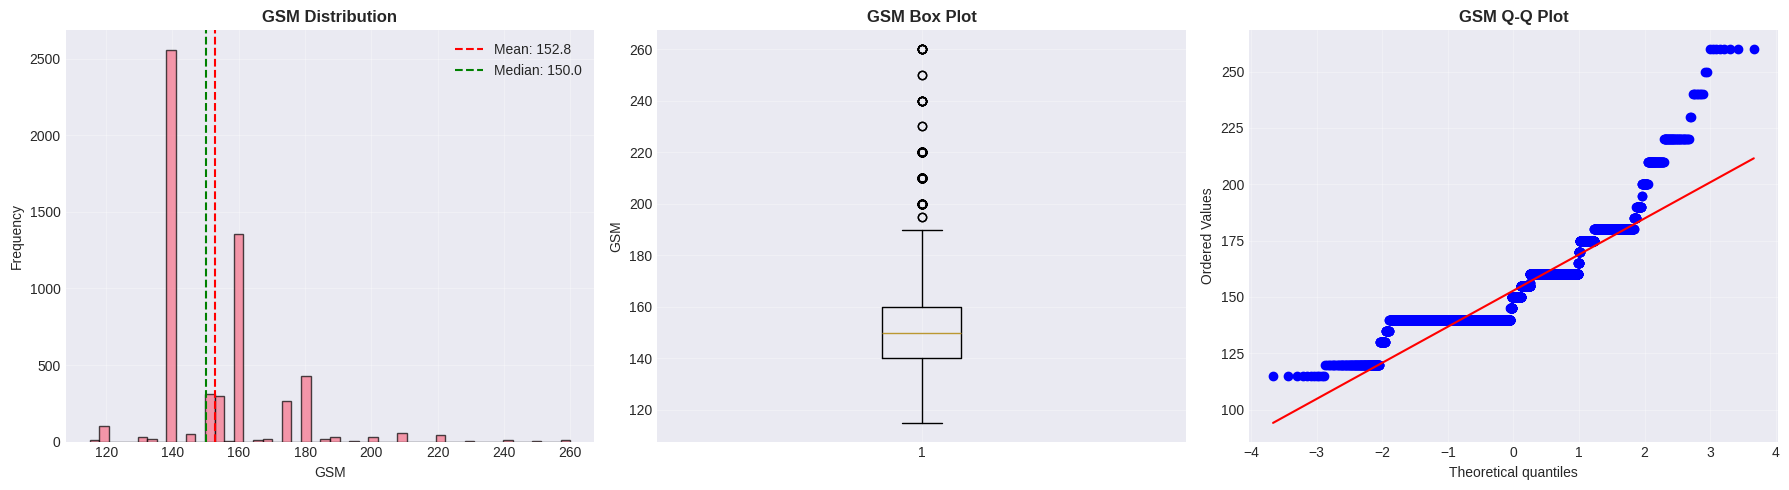

GSM Statistics:
  Mean: 152.82
  Std: 17.66
  Min: 115
  25%: 140.0
  50%: 150.0
  75%: 160.0
  Max: 260
  Range: 145
  CV: 11.56%


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(df['GSM'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(df['GSM'].mean(), color='red', linestyle='--', label=f"Mean: {df['GSM'].mean():.1f}")
axes[0].axvline(df['GSM'].median(), color='green', linestyle='--', label=f"Median: {df['GSM'].median():.1f}")
axes[0].set_xlabel('GSM')
axes[0].set_ylabel('Frequency')
axes[0].set_title('GSM Distribution', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(df['GSM'], vert=True)
axes[1].set_ylabel('GSM')
axes[1].set_title('GSM Box Plot', fontweight='bold')
axes[1].grid(alpha=0.3)

# QQ plot
from scipy import stats
stats.probplot(df['GSM'], dist="norm", plot=axes[2])
axes[2].set_title('GSM Q-Q Plot', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('gsm_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"GSM Statistics:")
print(f"  Mean: {df['GSM'].mean():.2f}")
print(f"  Std: {df['GSM'].std():.2f}")
print(f"  Min: {df['GSM'].min()}")
print(f"  25%: {df['GSM'].quantile(0.25)}")
print(f"  50%: {df['GSM'].median()}")
print(f"  75%: {df['GSM'].quantile(0.75)}")
print(f"  Max: {df['GSM'].max()}")
print(f"  Range: {df['GSM'].max() - df['GSM'].min()}")
print(f"  CV: {df['GSM'].std() / df['GSM'].mean() * 100:.2f}%")

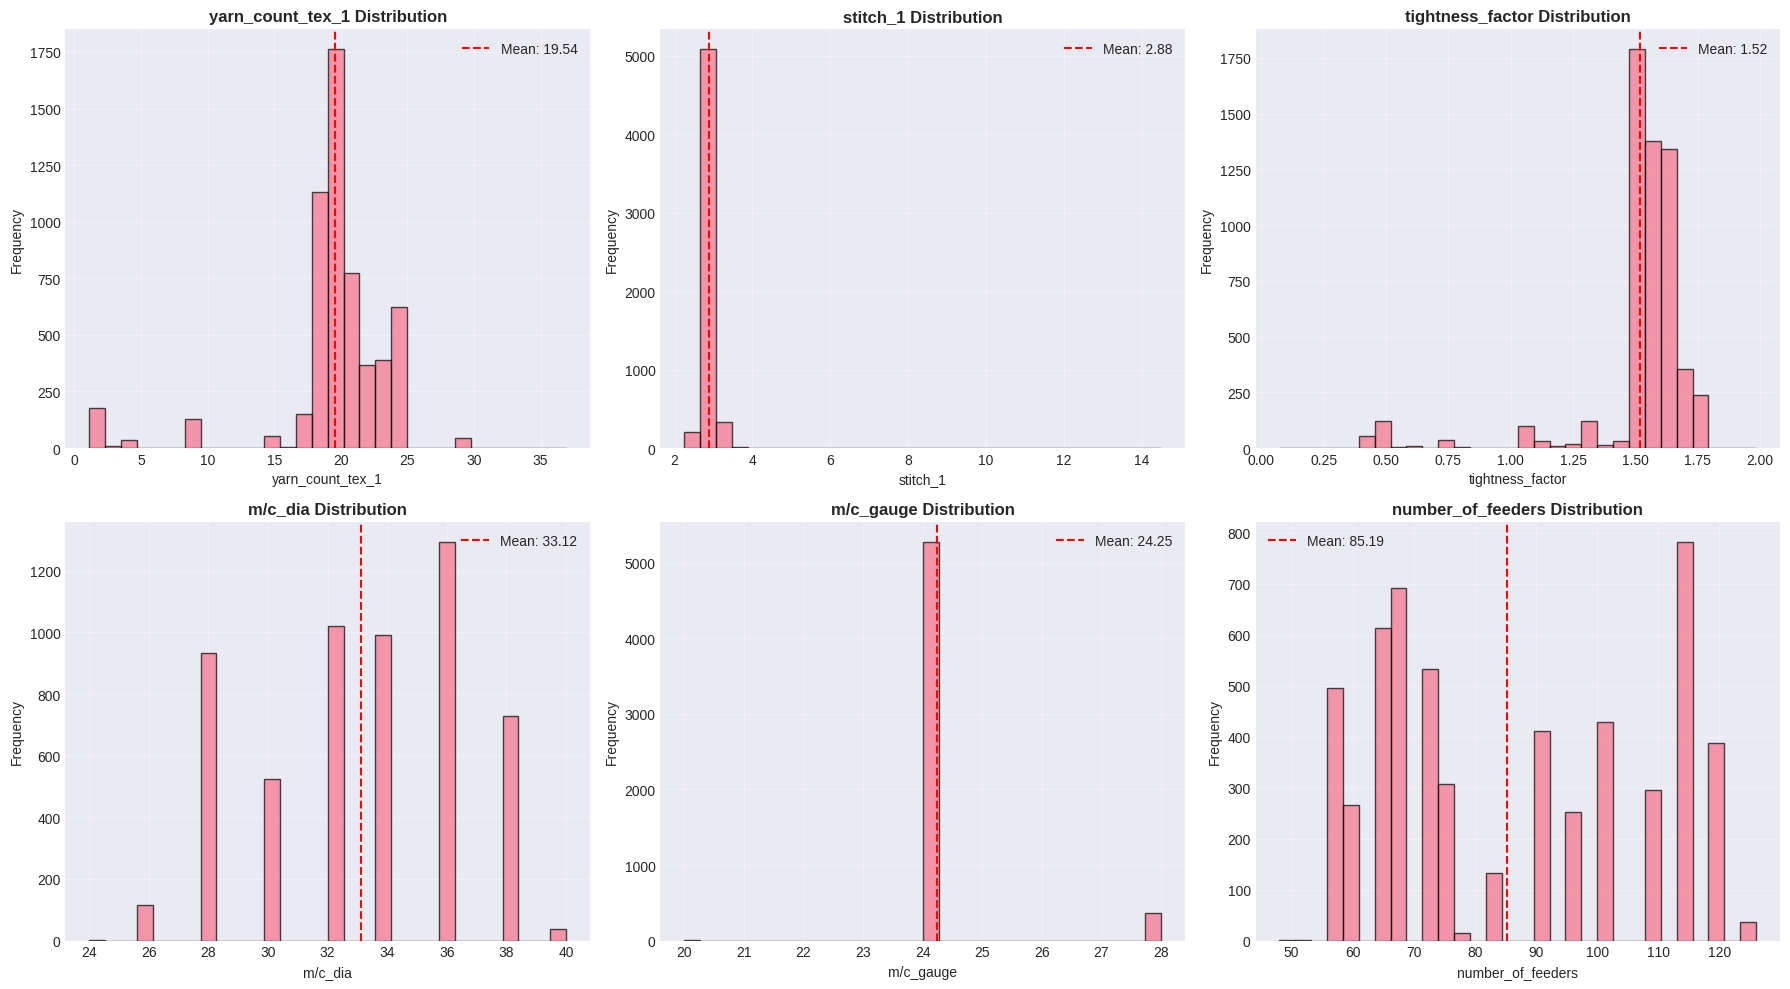

In [8]:
# Key features for S/J
feature_cols = ['yarn_count_tex_1', 'stitch_1', 'tightness_factor', 'm/c_dia', 'm/c_gauge', 'number_of_feeders']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    if col in df.columns:
        data = df[col].dropna()
        axes[idx].hist(data, bins=30, edgecolor='black', alpha=0.7)
        axes[idx].axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.2f}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(f'{col} Distribution', fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

### Physics Relationships - GSM vs Key Features

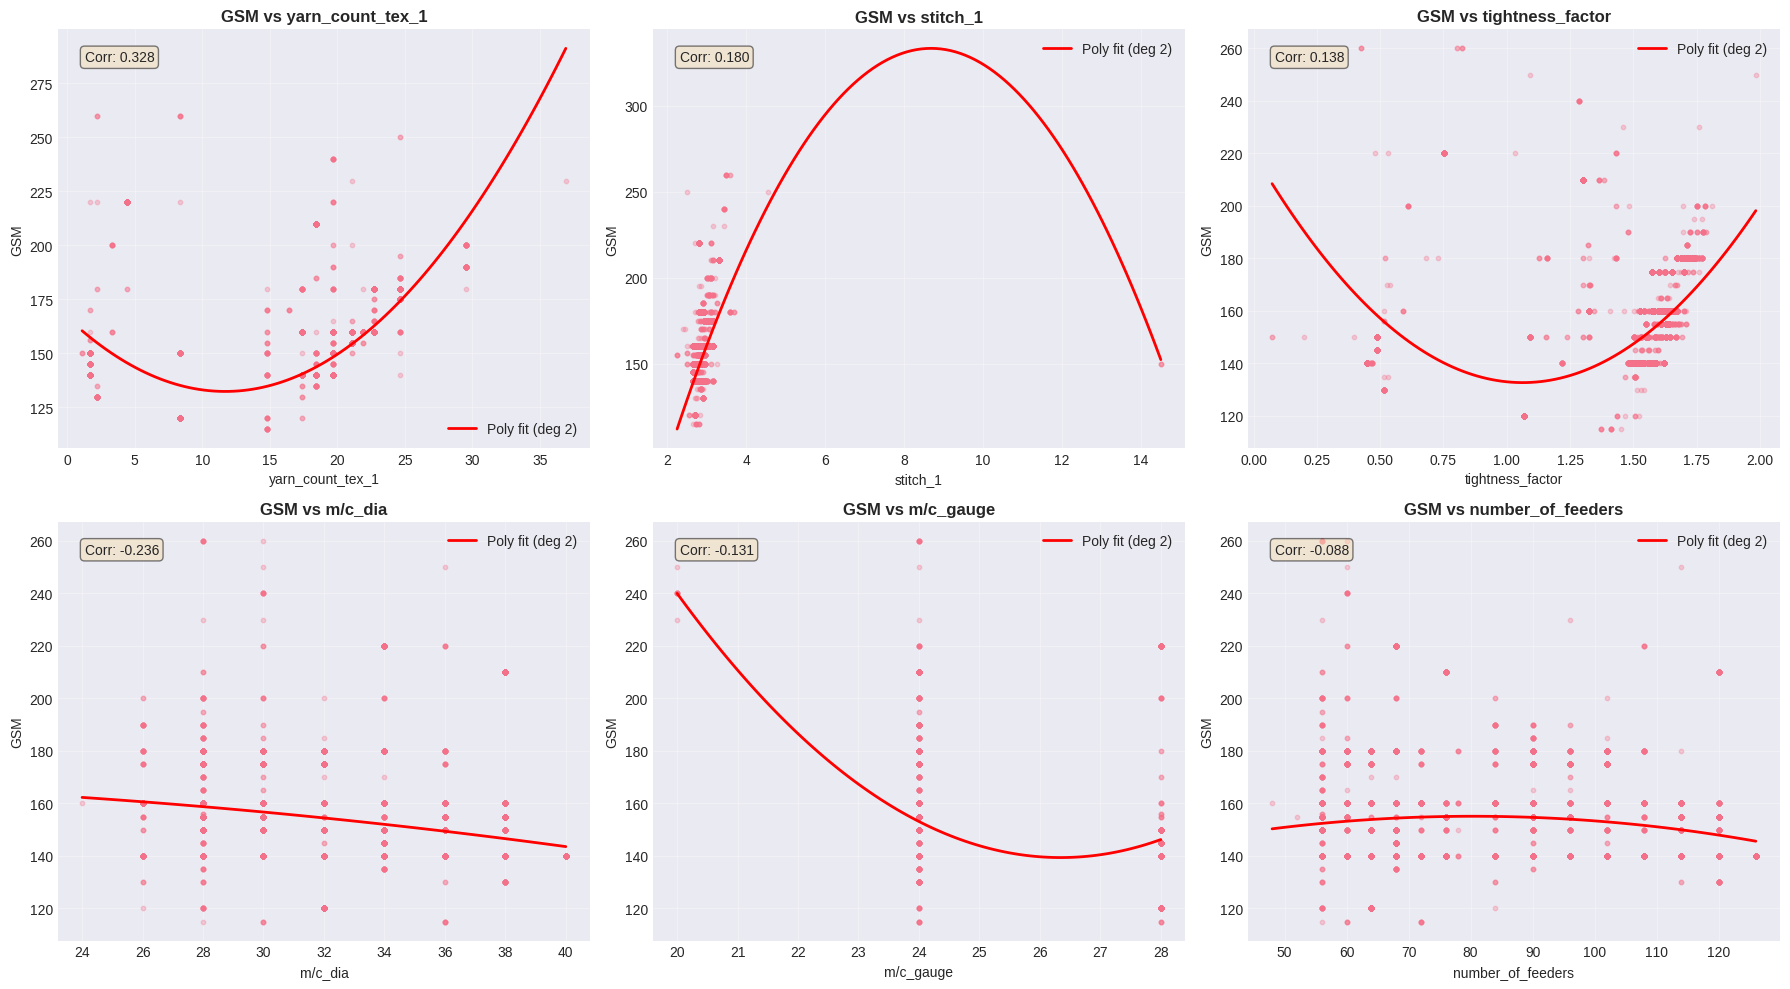


🔍 Physics Insights:
  yarn_count_tex_1         : correlation =  0.328
  stitch_1                 : correlation =  0.180
  tightness_factor         : correlation =  0.138
  m/c_dia                  : correlation = -0.236
  m/c_gauge                : correlation = -0.131
  number_of_feeders        : correlation = -0.088


In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(feature_cols):
    if col in df.columns:
        valid_data = df[[col, 'GSM']].dropna()
        axes[idx].scatter(valid_data[col], valid_data['GSM'], alpha=0.3, s=10)

        # Add trend line
        z = np.polyfit(valid_data[col], valid_data['GSM'], 2)  # polynomial degree 2
        p = np.poly1d(z)
        x_line = np.linspace(valid_data[col].min(), valid_data[col].max(), 100)
        axes[idx].plot(x_line, p(x_line), 'r-', linewidth=2, label='Poly fit (deg 2)')

        # Correlation
        corr = valid_data[col].corr(valid_data['GSM'])
        axes[idx].text(0.05, 0.95, f'Corr: {corr:.3f}',
                      transform=axes[idx].transAxes,
                      verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('GSM')
        axes[idx].set_title(f'GSM vs {col}', fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('physics_relationships.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n🔍 Physics Insights:")
for col in feature_cols:
    if col in df.columns:
        valid_data = df[[col, 'GSM']].dropna()
        corr = valid_data[col].corr(valid_data['GSM'])
        print(f"  {col:25s}: correlation = {corr:6.3f}")

### Correlation Matrix

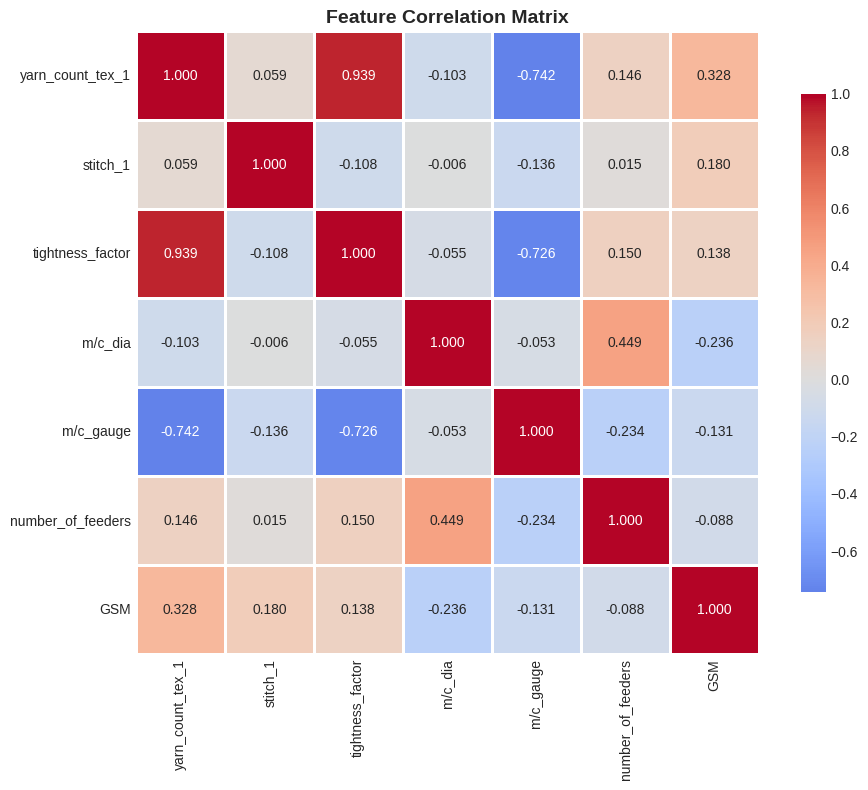


Top 5 correlations with GSM:
  yarn_count_tex_1         :  0.328
  m/c_dia                  : -0.236
  stitch_1                 :  0.180
  tightness_factor         :  0.138
  m/c_gauge                : -0.131


In [10]:
# Correlation heatmap
corr_cols = feature_cols + ['GSM']
corr_data = df[corr_cols].dropna()
corr_matrix = corr_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 5 correlations with GSM:")
gsm_corr = corr_matrix['GSM'].drop('GSM').abs().sort_values(ascending=False)
for feat, corr_val in gsm_corr.head().items():
    print(f"  {feat:25s}: {corr_matrix.loc[feat, 'GSM']:6.3f}")

###  Pairplot - Top Correlated Features

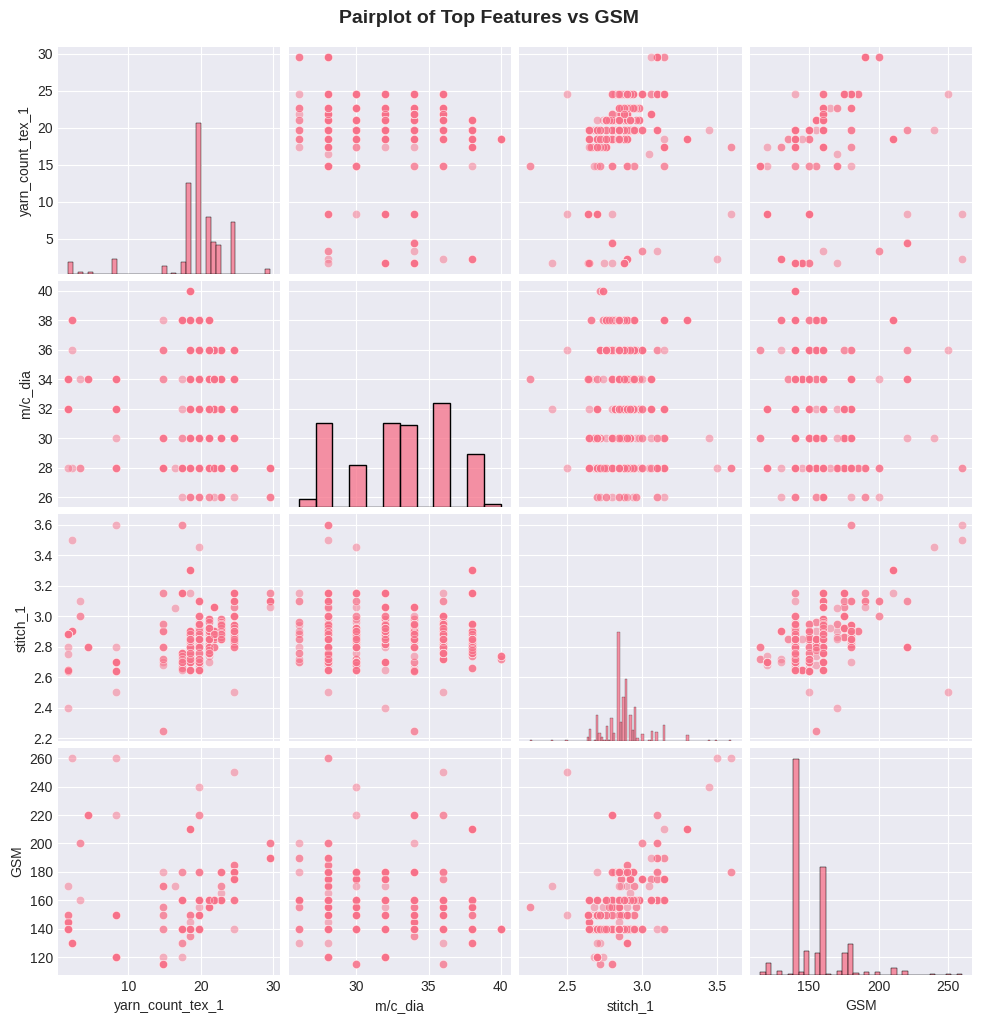

In [11]:
# Select top 3 features + GSM for pairplot
top_features = gsm_corr.head(3).index.tolist() + ['GSM']
pairplot_data = df[top_features].dropna().sample(min(1000, len(df)), random_state=RANDOM_STATE)

g = sns.pairplot(pairplot_data, diag_kind='hist', plot_kws={'alpha': 0.5})
g.fig.suptitle('Pairplot of Top Features vs GSM', y=1.02, fontsize=14, fontweight='bold')
plt.savefig('pairplot_top_features.png', dpi=300, bbox_inches='tight')
plt.show()

##  Feature Engineering & Data Preparation

In [13]:

feature_cols = ['yarn_count_tex_1', 'stitch_1', 'tightness_factor', 'm/c_dia', 'm/c_gauge', 'number_of_feeders']
df_clean = df[feature_cols + ['GSM']].dropna()

print(f"Clean dataset: {len(df_clean):,} samples ({len(df_clean)/len(df)*100:.1f}% of S/J)")
print(f"\nFeatures: {len(feature_cols)}")
for col in feature_cols:
    print(f"  - {col}")

X = df_clean[feature_cols].values
y = df_clean['GSM'].values
feature_names = feature_cols

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

Clean dataset: 5,648 samples (100.0% of S/J)

Features: 6
  - yarn_count_tex_1
  - stitch_1
  - tightness_factor
  - m/c_dia
  - m/c_gauge
  - number_of_feeders

X shape: (5648, 6)
y shape: (5648,)


### Train/Val/Test Split (70/15/15)

In [14]:
# 70/15/15 split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=RANDOM_STATE)

print(f"Train: {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val:   {len(X_val):,} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test:  {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"\n✅ Features scaled with StandardScaler")

Train: 3,952 (70.0%)
Val:   848 (15.0%)
Test:  848 (15.0%)

✅ Features scaled with StandardScaler


##  Model Training (~30 Models)

In [15]:
from sklearn.pipeline import Pipeline

# Define all models
models = {}

# Interpretable
models['OLS'] = ('Interpretable', LinearRegression())
models['Ridge'] = ('Interpretable', Ridge(random_state=RANDOM_STATE))
models['Lasso'] = ('Interpretable', Lasso(random_state=RANDOM_STATE))
models['ElasticNet'] = ('Interpretable', ElasticNet(random_state=RANDOM_STATE))
models['Bayesian Ridge'] = ('Interpretable', BayesianRidge())
models['Huber'] = ('Interpretable', HuberRegressor())
models['Poly-2 Ridge'] = ('Interpretable', Pipeline([('poly', PolynomialFeatures(degree=2)), ('ridge', Ridge(random_state=RANDOM_STATE))]))
models['Poly-3 Ridge'] = ('Interpretable', Pipeline([('poly', PolynomialFeatures(degree=3)), ('ridge', Ridge(alpha=10, random_state=RANDOM_STATE))]))
models['Decision Tree'] = ('Interpretable', DecisionTreeRegressor(max_depth=5, random_state=RANDOM_STATE))

# Black-Box
models['Random Forest'] = ('Black-Box', RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1))
models['Extra Trees'] = ('Black-Box', ExtraTreesRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1))
models['Gradient Boosting'] = ('Black-Box', GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE))
models['AdaBoost'] = ('Black-Box', AdaBoostRegressor(n_estimators=100, random_state=RANDOM_STATE))
models['SVR-RBF'] = ('Black-Box', SVR(kernel='rbf'))
models['SVR-Poly'] = ('Black-Box', SVR(kernel='poly', degree=2))
models['MLP-Small'] = ('Black-Box', MLPRegressor(hidden_layer_sizes=(32,), random_state=RANDOM_STATE, max_iter=1000))
models['MLP-Medium'] = ('Black-Box', MLPRegressor(hidden_layer_sizes=(64,32), random_state=RANDOM_STATE, max_iter=1000))
models['MLP-Large'] = ('Black-Box', MLPRegressor(hidden_layer_sizes=(128,64,32), random_state=RANDOM_STATE, max_iter=1000))
models['KNN'] = ('Black-Box', KNeighborsRegressor(n_neighbors=5))

if XGB:
    models['XGBoost'] = ('Black-Box', xgb.XGBRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1))
if LGB:
    models['LightGBM'] = ('Black-Box', lgb.LGBMRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1, verbose=-1))
if CB:
    models['CatBoost'] = ('Black-Box', CatBoostRegressor(iterations=100, random_state=RANDOM_STATE, verbose=0))

print(f"Total models: {len(models)}")
print(f"  Interpretable: {sum(1 for t,_ in models.values() if t=='Interpretable')}")
print(f"  Black-Box: {sum(1 for t,_ in models.values() if t=='Black-Box')}")

Total models: 22
  Interpretable: 9
  Black-Box: 13


In [17]:
# Train all models
results = []
trained_models = {}

print("="*80)
print("TRAINING MODELS")
print("="*80)

for name, (model_type, model) in models.items():
    start = time.time()
    try:
        # Use unscaled for tree models
        if any(x in name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB', 'Ada']):
            model.fit(X_train, y_train)
            y_test_pred = model.predict(X_test)
        else:
            model.fit(X_train_scaled, y_train)
            y_test_pred = model.predict(X_test_scaled)

        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        test_mape = mean_absolute_percentage_error(y_test, y_test_pred) * 100
        train_time = time.time() - start

        results.append({
            'Model': name,
            'Type': model_type,
            'Test_RMSE': test_rmse,
            'Test_MAE': test_mae,
            'Test_R2': test_r2,
            'Test_MAPE': test_mape,
            'Train_Time': train_time
        })

        trained_models[name] = (model, model_type)
        print(f"✓ {name:20s} | RMSE: {test_rmse:6.2f} | R²: {test_r2:.4f} | Time: {train_time:.2f}s")
    except Exception as e:
        print(f"✗ {name:20s} | ERROR: {str(e)[:50]}")

results_df = pd.DataFrame(results).sort_values('Test_RMSE')
print(f"\n Trained {len(results_df)} models successfully")

TRAINING MODELS
✓ OLS                  | RMSE:  15.05 | R²: 0.3494 | Time: 0.02s
✓ Ridge                | RMSE:  15.05 | R²: 0.3494 | Time: 0.04s
✓ Lasso                | RMSE:  16.23 | R²: 0.2435 | Time: 0.02s
✓ ElasticNet           | RMSE:  17.24 | R²: 0.1457 | Time: 0.01s
✓ Bayesian Ridge       | RMSE:  15.05 | R²: 0.3494 | Time: 0.01s
✓ Huber                | RMSE:  17.58 | R²: 0.1119 | Time: 0.09s
✓ Poly-2 Ridge         | RMSE:  10.28 | R²: 0.6965 | Time: 0.11s
✓ Poly-3 Ridge         | RMSE:   7.35 | R²: 0.8448 | Time: 0.04s
✓ Decision Tree        | RMSE:   7.61 | R²: 0.8335 | Time: 0.02s
✓ Random Forest        | RMSE:   5.36 | R²: 0.9175 | Time: 0.85s
✓ Extra Trees          | RMSE:   4.10 | R²: 0.9517 | Time: 0.53s
✓ Gradient Boosting    | RMSE:   5.92 | R²: 0.8994 | Time: 0.43s
✓ AdaBoost             | RMSE:   8.10 | R²: 0.8116 | Time: 0.15s
✓ SVR-RBF              | RMSE:  12.46 | R²: 0.5541 | Time: 2.16s
✓ SVR-Poly             | RMSE:  19.92 | R²: -0.1397 | Time: 2.32s
✓ MLP-Sm

##  Model Performance Results

In [18]:
# Display results
print("="*100)
print("TEST SET PERFORMANCE (Sorted by RMSE)")
print("="*100)
print(results_df[['Model', 'Type', 'Test_RMSE', 'Test_MAE', 'Test_R2', 'Test_MAPE']].to_string(index=False))

# Best models
best_overall = results_df.iloc[0]
best_interp = results_df[results_df['Type'] == 'Interpretable'].iloc[0]
best_blackbox = results_df[results_df['Type'] == 'Black-Box'].iloc[0]

print(f"\n{'='*80}")
print("BEST MODELS")
print(f"{'='*80}")
print(f"\n BEST OVERALL: {best_overall['Model']}")
print(f"   RMSE: {best_overall['Test_RMSE']:.2f} | R²: {best_overall['Test_R2']:.4f} | MAPE: {best_overall['Test_MAPE']:.2f}%")
print(f"\n BEST INTERPRETABLE: {best_interp['Model']}")
print(f"   RMSE: {best_interp['Test_RMSE']:.2f} | R²: {best_interp['Test_R2']:.4f} | MAPE: {best_interp['Test_MAPE']:.2f}%")
print(f"\n  BEST BLACK-BOX: {best_blackbox['Model']}")
print(f"   RMSE: {best_blackbox['Test_RMSE']:.2f} | R²: {best_blackbox['Test_R2']:.4f} | MAPE: {best_blackbox['Test_MAPE']:.2f}%")

# Interpretability trade-off
gap = (best_interp['Test_RMSE'] - best_blackbox['Test_RMSE']) / best_blackbox['Test_RMSE'] * 100
print(f"\n Interpretability Trade-off: {gap:.1f}% performance gap")
if gap < 10:
    print(f"    Use interpretable model (minimal gap)")
else:
    print(f"     Consider use case: interpretability vs accuracy")

TEST SET PERFORMANCE (Sorted by RMSE)
            Model          Type  Test_RMSE  Test_MAE   Test_R2  Test_MAPE
      Extra Trees     Black-Box   4.099259  0.786012  0.951720   0.467363
         CatBoost     Black-Box   4.465810  1.398115  0.942699   0.868014
          XGBoost     Black-Box   4.681684  0.936503  0.937026   0.560210
         LightGBM     Black-Box   5.230497  1.536957  0.921396   0.934713
    Random Forest     Black-Box   5.359110  0.981293  0.917483   0.571842
              KNN     Black-Box   5.375631  1.255896  0.916973   0.765322
       MLP-Medium     Black-Box   5.809764  2.933194  0.903022   1.854838
Gradient Boosting     Black-Box   5.918268  2.000863  0.899365   1.265996
        MLP-Large     Black-Box   5.943483  2.668838  0.898506   1.682961
     Poly-3 Ridge Interpretable   7.350788  4.457404  0.844752   2.892476
    Decision Tree Interpretable   7.611540  2.701651  0.833543   1.797934
         AdaBoost     Black-Box   8.098133  4.425421  0.811579   2.895814


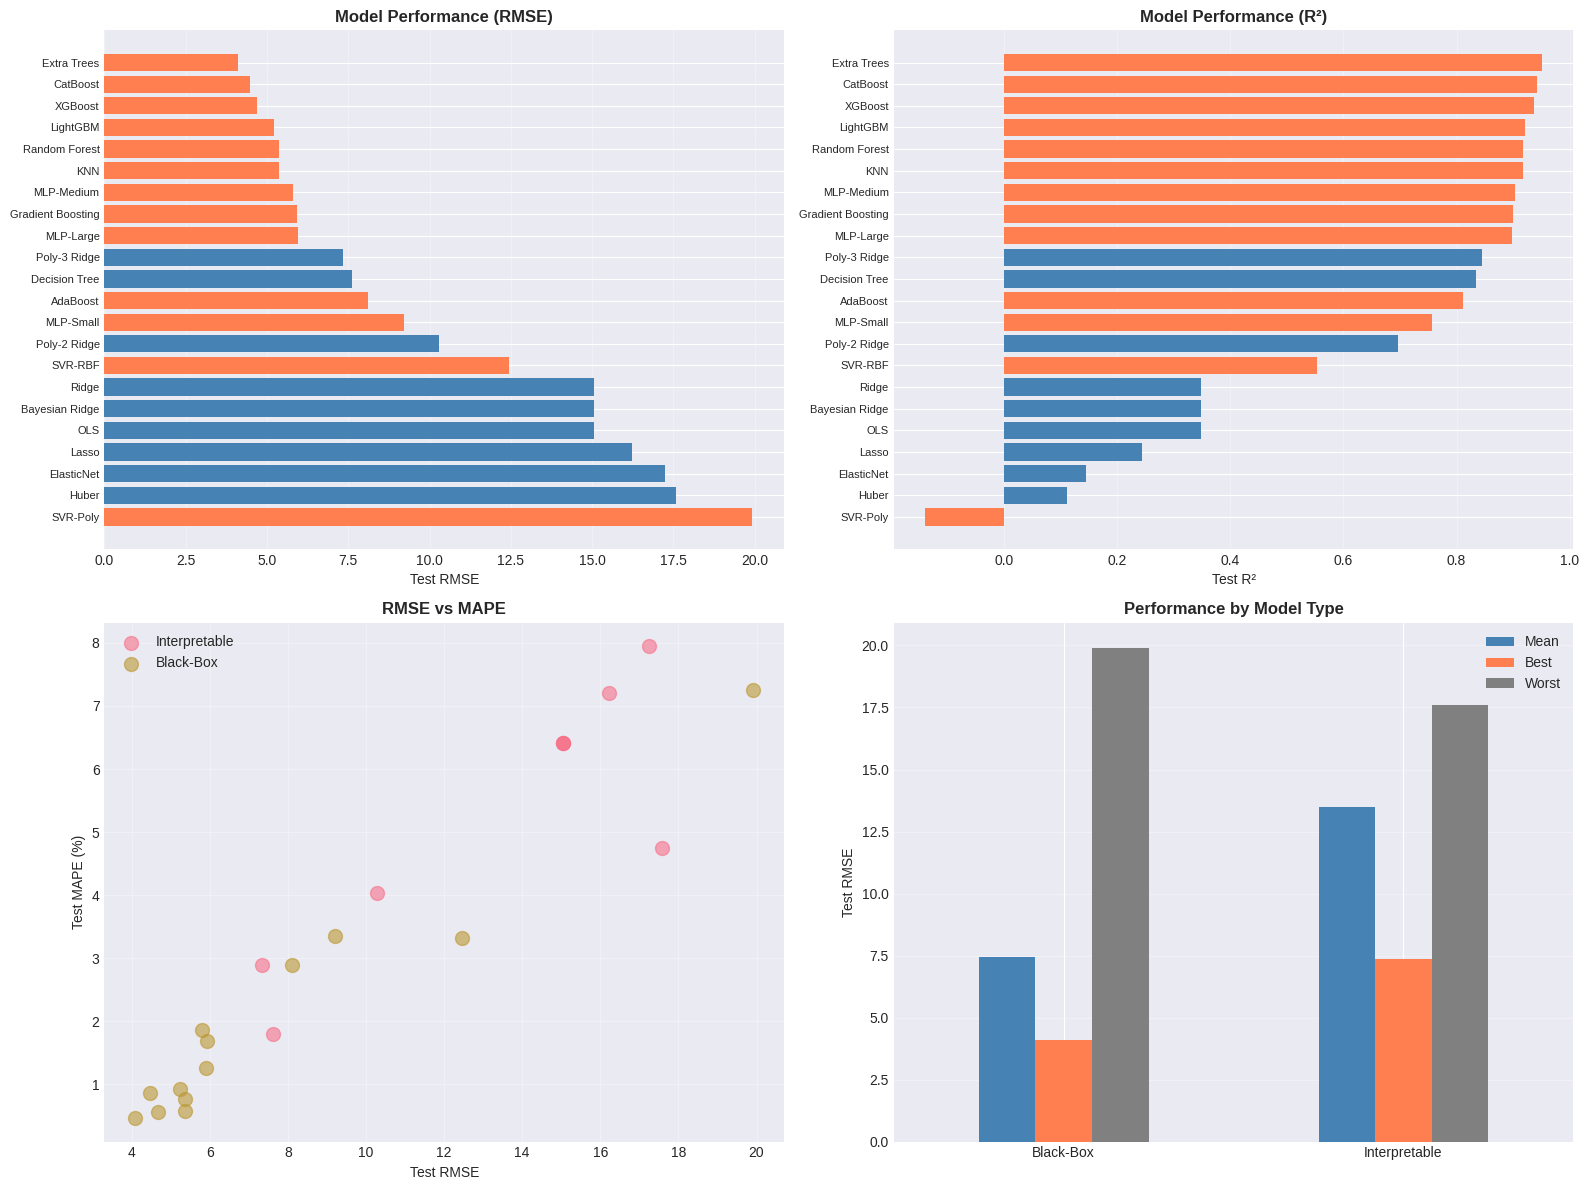

In [20]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#  RMSE comparison
ax = axes[0,0]
colors = ['steelblue' if t=='Interpretable' else 'coral' for t in results_df['Type']]
ax.barh(range(len(results_df)), results_df['Test_RMSE'], color=colors)
ax.set_yticks(range(len(results_df)))
ax.set_yticklabels(results_df['Model'], fontsize=8)
ax.set_xlabel('Test RMSE')
ax.set_title('Model Performance (RMSE)', fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

#  R² comparison
ax = axes[0,1]
ax.barh(range(len(results_df)), results_df['Test_R2'], color=colors)
ax.set_yticks(range(len(results_df)))
ax.set_yticklabels(results_df['Model'], fontsize=8)
ax.set_xlabel('Test R²')
ax.set_title('Model Performance (R²)', fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

#  RMSE vs MAPE
ax = axes[1,0]
for model_type in ['Interpretable', 'Black-Box']:
    subset = results_df[results_df['Type'] == model_type]
    ax.scatter(subset['Test_RMSE'], subset['Test_MAPE'], label=model_type, s=100, alpha=0.6)
ax.set_xlabel('Test RMSE')
ax.set_ylabel('Test MAPE (%)')
ax.set_title('RMSE vs MAPE', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)


ax = axes[1,1]
type_summary = results_df.groupby('Type')['Test_RMSE'].agg(['mean', 'min', 'max'])
type_summary.plot(kind='bar', ax=ax, color=['steelblue', 'coral', 'gray'])
ax.set_title('Performance by Model Type', fontweight='bold')
ax.set_ylabel('Test RMSE')
ax.set_xlabel('')
ax.tick_params(axis='x', rotation=0)
ax.legend(['Mean', 'Best', 'Worst'])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Hyperparameter tuning with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

print("="*80)
print("HYPERPARAMETER TUNING")
print("="*80)

# Define parameter grids for top models
param_grids = {
    'Extra Trees': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },

    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },

    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },

    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'num_leaves': [20, 31, 40, 50],
        'subsample': [0.8, 0.9, 1.0]
    },

    'CatBoost': {
        'iterations': [100, 200, 300],
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'l2_leaf_reg': [1, 3, 5, 7]
    },

    'SVR-RBF': {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
        'epsilon': [0.01, 0.1, 0.2, 0.5]
    }
}

print(f"Will tune {len(param_grids)} models")

HYPERPARAMETER TUNING
Will tune 6 models


In [22]:
# Perform hyperparameter tuning
tuned_models = {}
tuning_results = []

for model_name in param_grids.keys():
    if model_name not in trained_models:
        print(f"  {model_name} not found, skipping...")
        continue

    print(f"\n{'='*70}")
    print(f"Tuning: {model_name}")
    print('='*70)

    # Get base model and data
    base_model, model_type = trained_models[model_name]

    # Select appropriate data
    if any(x in model_name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB']):
        X_tune, y_tune = X_train, y_train
        X_eval = X_test
    else:
        X_tune, y_tune = X_train_scaled, y_train
        X_eval = X_test_scaled

    # Get base model class
    if model_name == 'Extra Trees':
        base_estimator = ExtraTreesRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    elif model_name == 'Random Forest':
        base_estimator = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    elif model_name == 'XGBoost':
        base_estimator = xgb.XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)
    elif model_name == 'LightGBM':
        base_estimator = lgb.LGBMRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
    elif model_name == 'CatBoost':
        base_estimator = CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)
    elif model_name == 'SVR-RBF':
        base_estimator = SVR(kernel='rbf')
    else:
        continue

    # RandomizedSearchCV
    random_search = RandomizedSearchCV(
        base_estimator,
        param_distributions=param_grids[model_name],
        n_iter=20,  #  20 random combinations
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=0
    )

    # Fit
    start = time.time()
    random_search.fit(X_tune, y_tune)
    tune_time = time.time() - start

    # Best model predictions
    y_pred_tuned = random_search.best_estimator_.predict(X_eval)

    # Metrics
    tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    tuned_mae = mean_absolute_error(y_test, y_pred_tuned)
    tuned_r2 = r2_score(y_test, y_pred_tuned)
    tuned_mape = mean_absolute_percentage_error(y_test, y_pred_tuned) * 100

    # Original performance
    original_rmse = results_df[results_df['Model'] == model_name]['Test_RMSE'].values[0]
    improvement = (original_rmse - tuned_rmse) / original_rmse * 100

    print(f"\n Tuning complete in {tune_time:.1f}s")
    print(f"   Original RMSE: {original_rmse:.2f}")
    print(f"   Tuned RMSE:    {tuned_rmse:.2f}")
    print(f"   Improvement:   {improvement:+.2f}%")
    print(f"\n   Best parameters:")
    for param, value in random_search.best_params_.items():
        print(f"     {param}: {value}")

    # Store results
    tuned_models[model_name] = (random_search.best_estimator_, model_type)

    tuning_results.append({
        'Model': f'{model_name}-Tuned',
        'Type': model_type,
        'Test_RMSE': tuned_rmse,
        'Test_MAE': tuned_mae,
        'Test_R2': tuned_r2,
        'Test_MAPE': tuned_mape,
        'Original_RMSE': original_rmse,
        'Improvement_%': improvement,
        'Tune_Time': tune_time,
        'Best_Params': str(random_search.best_params_)
    })

tuning_df = pd.DataFrame(tuning_results)
print(f"\n{'='*70}")
print(f" Hyperparameter tuning complete for {len(tuning_df)} models")


Tuning: Extra Trees

 Tuning complete in 45.9s
   Original RMSE: 4.10
   Tuned RMSE:    4.33
   Improvement:   -5.62%

   Best parameters:
     n_estimators: 100
     min_samples_split: 5
     min_samples_leaf: 1
     max_features: None
     max_depth: 20

Tuning: Random Forest

 Tuning complete in 45.0s
   Original RMSE: 5.36
   Tuned RMSE:    4.52
   Improvement:   +15.71%

   Best parameters:
     n_estimators: 200
     min_samples_split: 2
     min_samples_leaf: 1
     max_features: log2
     max_depth: 30

Tuning: XGBoost

 Tuning complete in 12.5s
   Original RMSE: 4.68
   Tuned RMSE:    4.52
   Improvement:   +3.43%

   Best parameters:
     subsample: 0.8
     n_estimators: 300
     max_depth: 5
     learning_rate: 0.05
     colsample_bytree: 0.9

Tuning: LightGBM

 Tuning complete in 46.4s
   Original RMSE: 5.23
   Tuned RMSE:    4.56
   Improvement:   +12.82%

   Best parameters:
     subsample: 0.8
     num_leaves: 40
     n_estimators: 300
     max_depth: 5
     learning_r

In [23]:


import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

tuned_summary = []

for model_name, (model, model_type) in tuned_models.items():

    # Select correct feature space
    if any(x in model_name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB']):
        X_tr, X_te = X_train, X_test
    else:
        X_tr, X_te = X_train_scaled, X_test_scaled

    # Predictions
    y_tr_pred = model.predict(X_tr)
    y_te_pred = model.predict(X_te)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_tr_pred))
    test_rmse  = np.sqrt(mean_squared_error(y_test, y_te_pred))
    test_mae   = mean_absolute_error(y_test, y_te_pred)
    test_r2    = r2_score(y_test, y_te_pred)
    test_mape  = mean_absolute_percentage_error(y_test, y_te_pred) * 100

    # Overfitting gap (RMSE)
    rmse_gap = ((test_rmse - train_rmse) / train_rmse) * 100

    tuned_summary.append({
        'Model': model_name,
        'Type': model_type,
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Test R²': test_r2,
        'Test MAE': test_mae,
        'Test MAPE (%)': test_mape,
        'RMSE Gap (%)': rmse_gap
    })

# Create final DataFrame
tuned_df = pd.DataFrame(tuned_summary).sort_values('Test RMSE')

print("\nTUNED MODELS – FINAL PERFORMANCE SUMMARY")
print("="*70)
print(tuned_df.to_string(index=False))



TUNED MODELS – FINAL PERFORMANCE SUMMARY
        Model      Type  Train RMSE  Test RMSE  Test R²  Test MAE  Test MAPE (%)  RMSE Gap (%)
  Extra Trees Black-Box    1.477891   4.329605 0.946141  0.877526       0.523262    192.958244
Random Forest Black-Box    1.616606   4.517055 0.941377  0.928240       0.558259    179.415876
      XGBoost Black-Box    1.710178   4.521250 0.941268  1.189936       0.730265    164.373122
     LightGBM Black-Box    2.035291   4.560188 0.940252  1.265370       0.784038    124.055807
     CatBoost Black-Box    2.066032   4.981496 0.928702  1.513905       0.938193    141.114131
      SVR-RBF Black-Box    4.999212   6.714477 0.870466  2.743856       1.731647     34.310721


In [24]:
# Add tuned models to results_df
for _, row in tuning_df.iterrows():
    results_df = pd.concat([results_df, pd.DataFrame([{
        'Model': row['Model'],
        'Type': row['Type'],
        'Test_RMSE': row['Test_RMSE'],
        'Test_MAE': row['Test_MAE'],
        'Test_R2': row['Test_R2'],
        'Test_MAPE': row['Test_MAPE']
    }])], ignore_index=True)

results_df = results_df.sort_values('Test_RMSE').reset_index(drop=True)

# Update trained_models dict
for model_name, (model, model_type) in tuned_models.items():
    trained_models[f'{model_name}-Tuned'] = (model, model_type)

print(f" Updated results_df: now {len(results_df)} models")

 Updated results_df: now 28 models


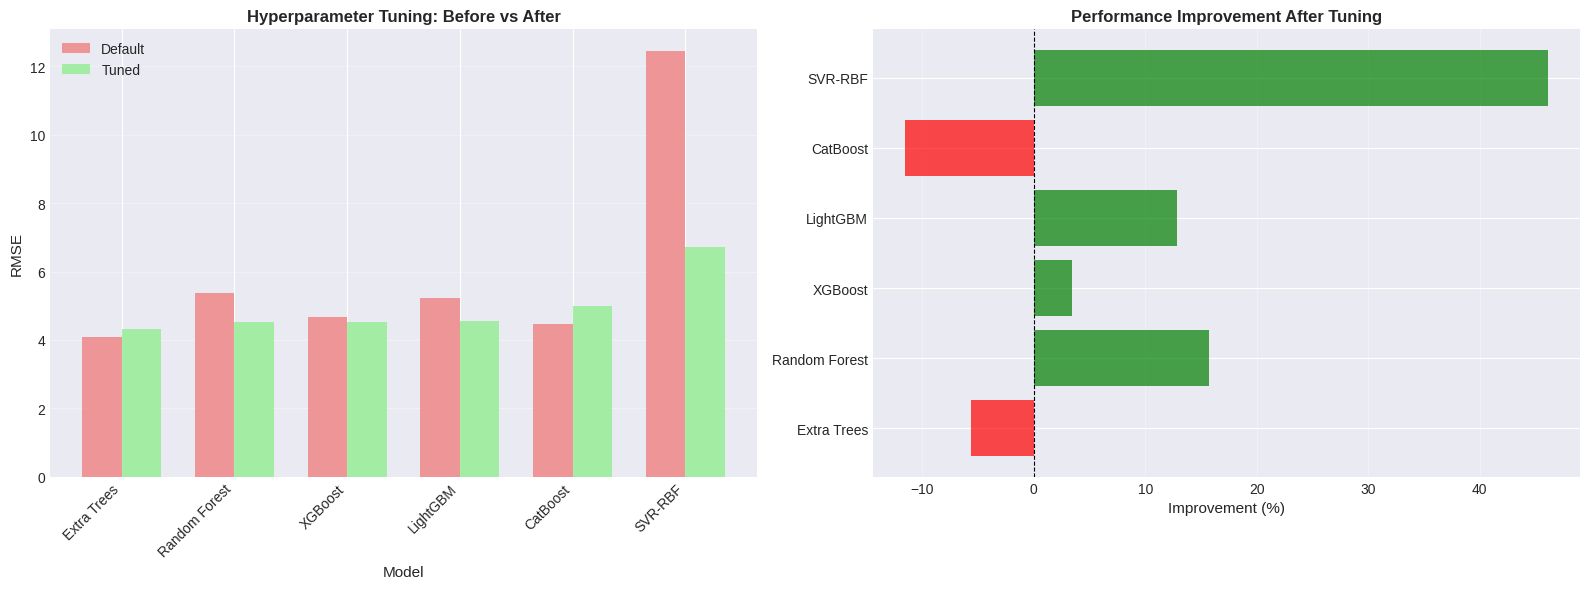


 Tuning visualization saved

 Summary:
   Average improvement: 10.15%
   Best improvement: 46.10% (SVR-RBF-Tuned)
   Models improved: 4/6


In [25]:
# Visualize tuning improvements
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

#  Before/After comparison
ax = axes[0]
models_tuned = tuning_df['Model'].str.replace('-Tuned', '').tolist()
original_rmse = tuning_df['Original_RMSE'].values
tuned_rmse = tuning_df['Test_RMSE'].values

x = np.arange(len(models_tuned))
width = 0.35

ax.bar(x - width/2, original_rmse, width, label='Default', color='lightcoral', alpha=0.8)
ax.bar(x + width/2, tuned_rmse, width, label='Tuned', color='lightgreen', alpha=0.8)

ax.set_xlabel('Model', fontsize=11)
ax.set_ylabel('RMSE', fontsize=11)
ax.set_title('Hyperparameter Tuning: Before vs After', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models_tuned, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

#  Improvement percentage
ax = axes[1]
improvements = tuning_df['Improvement_%'].values
colors = ['green' if x > 0 else 'red' for x in improvements]

ax.barh(models_tuned, improvements, color=colors, alpha=0.7)
ax.set_xlabel('Improvement (%)', fontsize=11)
ax.set_title('Performance Improvement After Tuning', fontweight='bold')
ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('hyperparameter_tuning_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Tuning visualization saved")
print("\n Summary:")
print(f"   Average improvement: {tuning_df['Improvement_%'].mean():.2f}%")
print(f"   Best improvement: {tuning_df['Improvement_%'].max():.2f}% ({tuning_df.loc[tuning_df['Improvement_%'].idxmax(), 'Model']})")
print(f"   Models improved: {(tuning_df['Improvement_%'] > 0).sum()}/{len(tuning_df)}")

In [26]:
# Update best overall and best interpretable after tuning
best_overall = results_df.iloc[0]
best_interp = results_df[results_df['Type'] == 'Interpretable'].iloc[0]
best_blackbox = results_df[results_df['Type'] == 'Black-Box'].iloc[0]

print("="*80)
print("UPDATED BEST MODELS (After Tuning)")
print("="*80)

print(f"\n BEST OVERALL: {best_overall['Model']}")
print(f"   RMSE: {best_overall['Test_RMSE']:.2f} | R²: {best_overall['Test_R2']:.4f} | MAPE: {best_overall['Test_MAPE']:.2f}%")

print(f"\n BEST INTERPRETABLE: {best_interp['Model']}")
print(f"   RMSE: {best_interp['Test_RMSE']:.2f} | R²: {best_interp['Test_R2']:.4f} | MAPE: {best_interp['Test_MAPE']:.2f}%")

print(f"\n  BEST BLACK-BOX: {best_blackbox['Model']}")
print(f"   RMSE: {best_blackbox['Test_RMSE']:.2f} | R²: {best_blackbox['Test_R2']:.4f} | MAPE: {best_blackbox['Test_MAPE']:.2f}%")

# Check if tuning helped the best model
if '-Tuned' in best_overall['Model']:
    print("\n Tuning improved the best model!")
else:
    print("\n Default parameters were already near-optimal for best model")

UPDATED BEST MODELS (After Tuning)

 BEST OVERALL: Extra Trees
   RMSE: 4.10 | R²: 0.9517 | MAPE: 0.47%

 BEST INTERPRETABLE: Poly-3 Ridge
   RMSE: 7.35 | R²: 0.8448 | MAPE: 2.89%

  BEST BLACK-BOX: Extra Trees
   RMSE: 4.10 | R²: 0.9517 | MAPE: 0.47%

 Default parameters were already near-optimal for best model


In [27]:
try:
    from pygam import LinearGAM, s
    print(' pygam available')
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'pygam', '-q'])
    from pygam import LinearGAM, s
    print(' pygam installed')

 pygam installed


In [28]:

# GENERALIZED ADDITIVE MODEL (GAM)


from pygam import LinearGAM, s
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import time

print("="*70)
print("GENERALIZED ADDITIVE MODEL (GAM) – PERFORMANCE SUMMARY")
print("="*70)

# Train GAM
gam = LinearGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5))

start = time.time()
gam.gridsearch(X_train, y_train)
gam_time = time.time() - start

# Predictions
y_train_pred = gam.predict(X_train)
y_test_pred  = gam.predict(X_test)

# Metrics
gam_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
gam_test_rmse  = np.sqrt(mean_squared_error(y_test, y_test_pred))
gam_test_mae   = mean_absolute_error(y_test, y_test_pred)
gam_test_r2    = r2_score(y_test, y_test_pred)
gam_test_mape  = mean_absolute_percentage_error(y_test, y_test_pred) * 100

# Simple overfitting indicator (RMSE gap only)
rmse_gap = ((gam_test_rmse - gam_train_rmse) / gam_train_rmse) * 100


gam_summary = pd.DataFrame([{
    'Model': 'GAM',
    'Type': 'Interpretable',
    'Train RMSE': gam_train_rmse,
    'Test RMSE': gam_test_rmse,
    'Test R²': gam_test_r2,
    'Test MAE': gam_test_mae,
    'Test MAPE (%)': gam_test_mape,
    'RMSE Gap (%)': rmse_gap
}])

print("\nGAM TRAINING TIME (s): {:.2f}".format(gam_time))
print("\nGAM PERFORMANCE (TRAIN vs TEST)")
print("-"*70)
print(gam_summary.to_string(index=False))


results_df = pd.concat([
    results_df,
    gam_summary.rename(columns={
        'Train RMSE': 'Train_RMSE',
        'Test RMSE': 'Test_RMSE',
        'Test R²': 'Test_R2',
        'Test MAE': 'Test_MAE',
        'Test MAPE (%)': 'Test_MAPE'
    })[['Model','Type','Train_RMSE','Test_RMSE','Test_MAE','Test_R2','Test_MAPE']]
], ignore_index=True).sort_values('Test_RMSE')

# Store model
trained_models['GAM'] = (gam, 'Interpretable')

print("\nGAM evaluation completed.")


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

GENERALIZED ADDITIVE MODEL (GAM) – PERFORMANCE SUMMARY


100% (11 of 11) |########################| Elapsed Time: 0:00:09 Time:  0:00:09



GAM TRAINING TIME (s): 9.44

GAM PERFORMANCE (TRAIN vs TEST)
----------------------------------------------------------------------
Model          Type  Train RMSE  Test RMSE  Test R²  Test MAE  Test MAPE (%)  RMSE Gap (%)
  GAM Interpretable     5.25271   7.527495 0.837198  3.608264       2.292273     43.306862

GAM evaluation completed.


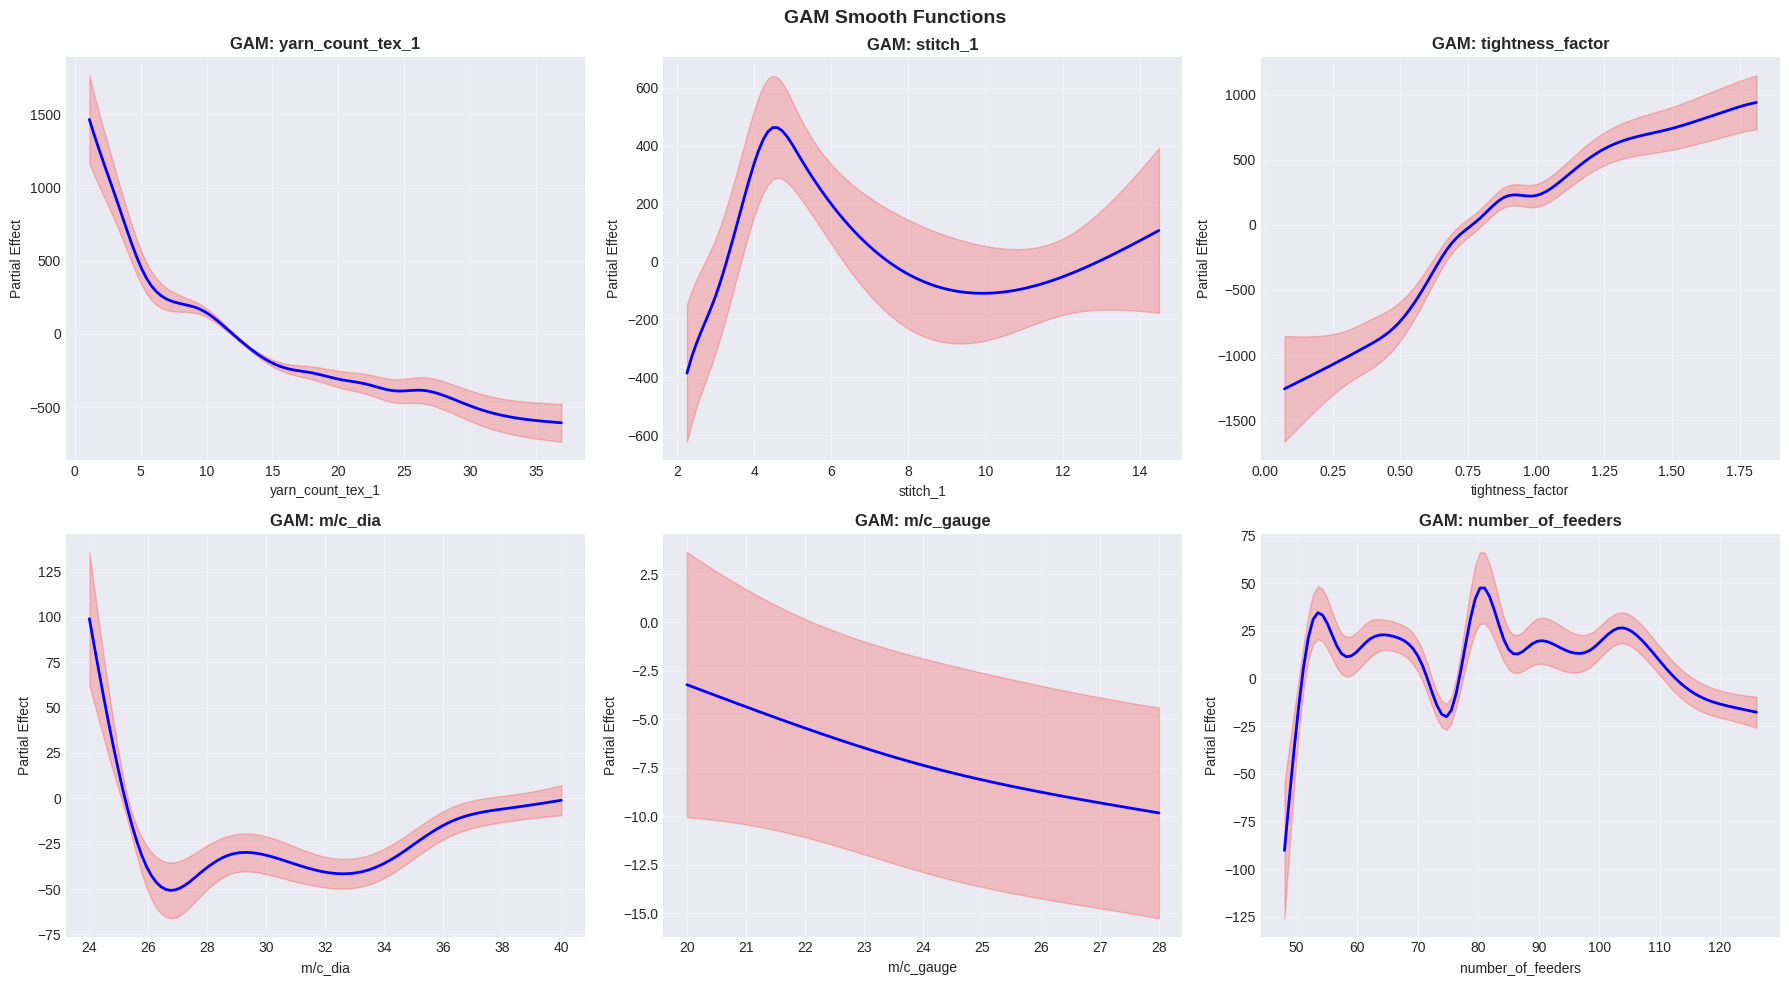

 GAM visualized


In [29]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()
for i in range(len(feature_names)):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    axes[i].plot(XX[:, i], pdep, 'b-', linewidth=2)
    axes[i].fill_between(XX[:, i], confi[:, 0], confi[:, 1], alpha=0.2, color='red')
    axes[i].set_xlabel(feature_names[i])
    axes[i].set_ylabel('Partial Effect')
    axes[i].set_title(f'GAM: {feature_names[i]}', fontweight='bold')
    axes[i].grid(alpha=0.3)
plt.suptitle('GAM Smooth Functions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('gam_partial_effects.png', dpi=300, bbox_inches='tight')
plt.show()
print(' GAM visualized')

In [30]:

# ADVANCED ENSEMBLE METHODS – TEST SET PERFORMANCE ONLY

from sklearn.ensemble import BaggingRegressor, StackingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd

ensemble_results = []

def eval_test(name, model_type, model, X_te):
    y_pred = model.predict(X_te)
    ensemble_results.append({
        'Model': name,
        'Type': model_type,
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'Test R²': r2_score(y_test, y_pred),
        'Test MAPE (%)': mean_absolute_percentage_error(y_test, y_pred) * 100
    })

bag_ridge = BaggingRegressor(
    estimator=Ridge(),
    n_estimators=50,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
bag_ridge.fit(X_train_scaled, y_train)
eval_test('Bagging-Ridge', 'Black-Box', bag_ridge, X_test_scaled)
trained_models['Bagging-Ridge'] = (bag_ridge, 'Black-Box')

bag_tree = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=10),
    n_estimators=50,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
bag_tree.fit(X_train, y_train)
eval_test('Bagging-Tree', 'Black-Box', bag_tree, X_test)
trained_models['Bagging-Tree'] = (bag_tree, 'Black-Box')

stacking = StackingRegressor(
    estimators=[
        ('ridge', Ridge()),
        ('tree', DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE)),
        ('rf', RandomForestRegressor(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1))
    ],
    final_estimator=Ridge(),
    cv=5
)
stacking.fit(X_train_scaled, y_train)
eval_test('Stacking', 'Black-Box', stacking, X_test_scaled)
trained_models['Stacking'] = (stacking, 'Black-Box')

voting_estimators = [
    ('rf', RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)),
    ('et', ExtraTreesRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1))
]

if XGB:
    voting_estimators.append(
        ('xgb', xgb.XGBRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1))
    )

voting = VotingRegressor(estimators=voting_estimators)
voting.fit(X_train, y_train)
eval_test('Voting', 'Black-Box', voting, X_test)
trained_models['Voting'] = (voting, 'Black-Box')

ensemble_test_df = pd.DataFrame(ensemble_results).sort_values('Test RMSE')
ensemble_test_df


Model       Type  Test RMSE   Test R²  Test MAPE (%)
3         Voting  Black-Box   4.540311  0.940772       0.522479
2       Stacking  Black-Box   5.463937  0.914223       0.698456
1   Bagging-Tree  Black-Box   5.521934  0.912393       0.742569
0  Bagging-Ridge  Black-Box  15.050378  0.349192       6.445321

In [31]:
print('='*80)
print('CROSS-VALIDATION ANALYSIS')
print('='*80)

top_10 = results_df.head(10)['Model'].tolist()
cv_results = []

for model_name in top_10:
    if model_name not in trained_models:
        continue
    model, model_type = trained_models[model_name]
    tree_kw = ['Tree', 'Forest', 'Boost', 'XGB', 'LGB', 'CatB', 'Bagging', 'Voting', 'Ada', 'GAM']
    X_cv = X_train if any(k in model_name for k in tree_kw) else X_train_scaled
    try:
        cv_scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        cv_rmse = np.sqrt(-cv_scores)
        test_rmse = results_df[results_df['Model'] == model_name]['Test_RMSE'].values[0]
        cv_results.append({'Model': model_name, 'Type': model_type, 'CV_RMSE_Mean': cv_rmse.mean(), 'CV_RMSE_Std': cv_rmse.std(), 'Test_RMSE': test_rmse})
        print(f'{model_name:20s} | CV: {cv_rmse.mean():.2f}±{cv_rmse.std():.2f} | Test: {test_rmse:.2f}')
    except:
        pass

cv_df = pd.DataFrame(cv_results)
print(f'\n CV complete for {len(cv_df)} models')

CROSS-VALIDATION ANALYSIS
Extra Trees          | CV: 2.81±0.47 | Test: 4.10
Extra Trees-Tuned    | CV: 2.82±0.45 | Test: 4.33
CatBoost             | CV: 3.56±0.70 | Test: 4.47
Random Forest-Tuned  | CV: 3.12±0.74 | Test: 4.52
XGBoost-Tuned        | CV: 3.33±0.80 | Test: 4.52
LightGBM-Tuned       | CV: 3.38±0.67 | Test: 4.56
XGBoost              | CV: 3.61±1.17 | Test: 4.68
CatBoost-Tuned       | CV: 3.50±0.64 | Test: 4.98
LightGBM             | CV: 4.06±0.78 | Test: 5.23
Random Forest        | CV: 3.59±1.01 | Test: 5.36

 CV complete for 10 models


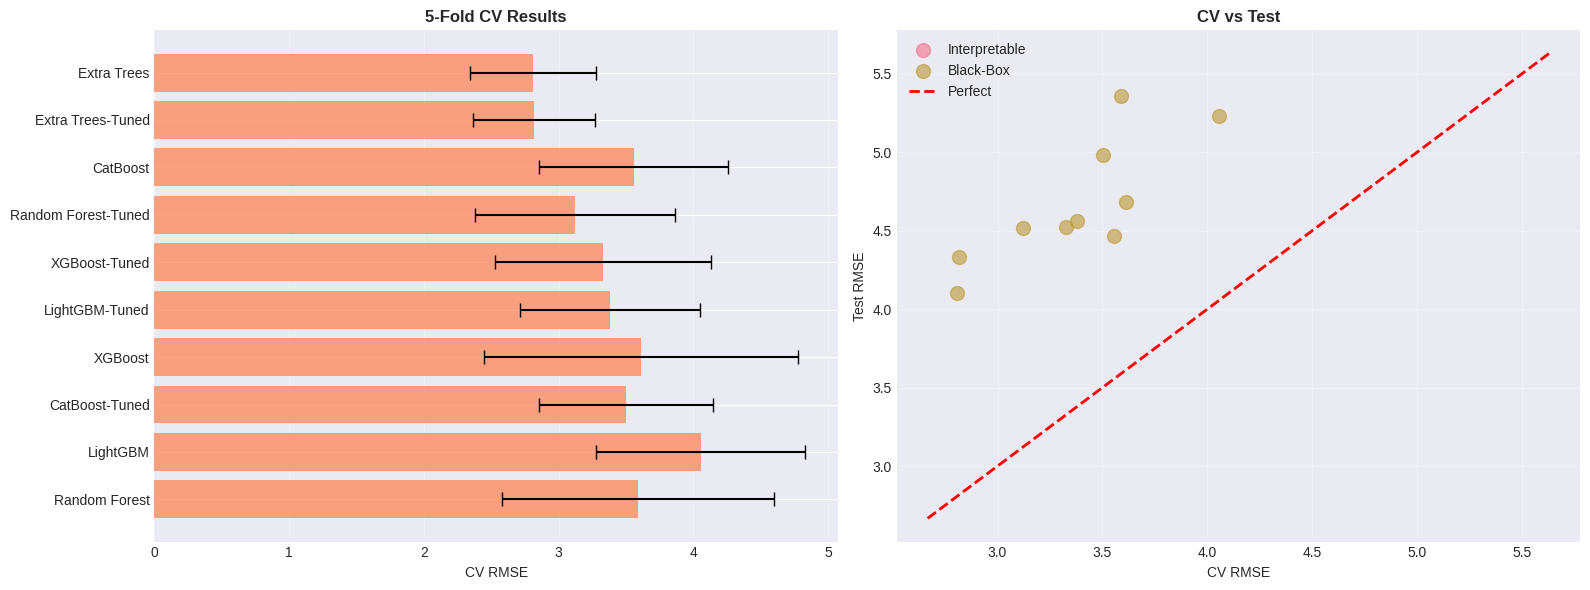

 CV viz created


In [32]:
if len(cv_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ax = axes[0]
    colors = ['steelblue' if t=='Interpretable' else 'coral' for t in cv_df['Type']]
    ax.barh(range(len(cv_df)), cv_df['CV_RMSE_Mean'], xerr=cv_df['CV_RMSE_Std'], color=colors, alpha=0.7, capsize=5)
    ax.set_yticks(range(len(cv_df)))
    ax.set_yticklabels(cv_df['Model'])
    ax.set_xlabel('CV RMSE')
    ax.set_title('5-Fold CV Results', fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    ax = axes[1]
    for mt in ['Interpretable', 'Black-Box']:
        subset = cv_df[cv_df['Type']==mt]
        ax.scatter(subset['CV_RMSE_Mean'], subset['Test_RMSE'], label=mt, s=100, alpha=0.6)
    mn, mx = min(cv_df['CV_RMSE_Mean'].min(), cv_df['Test_RMSE'].min())*0.95, max(cv_df['CV_RMSE_Mean'].max(), cv_df['Test_RMSE'].max())*1.05
    ax.plot([mn,mx], [mn,mx], 'r--', linewidth=2, label='Perfect')
    ax.set_xlabel('CV RMSE')
    ax.set_ylabel('Test RMSE')
    ax.set_title('CV vs Test', fontweight='bold')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('cross_validation_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(' CV viz created')

In [33]:
print('='*80)
print('FEATURE ENGINEERING EXPERIMENTS')
print('='*80)

tex_idx = list(feature_names).index('yarn_count_tex_1')
stitch_idx = list(feature_names).index('stitch_1')
tf_idx = list(feature_names).index('tightness_factor')

#  Interactions
print('\n1. INTERACTIONS')
X_tr_int = np.column_stack([X_train, X_train[:,tex_idx]*X_train[:,tf_idx], X_train[:,tex_idx]*X_train[:,stitch_idx], X_train[:,stitch_idx]*X_train[:,tf_idx]])
X_te_int = np.column_stack([X_test, X_test[:,tex_idx]*X_test[:,tf_idx], X_test[:,tex_idx]*X_test[:,stitch_idx], X_test[:,stitch_idx]*X_test[:,tf_idx]])
rf_int = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
rf_int.fit(X_tr_int, y_train)
rmse_int = np.sqrt(mean_squared_error(y_test, rf_int.predict(X_te_int)))
rf_base = results_df[results_df['Model']=='Random Forest']['Test_RMSE'].values[0]
print(f'RF: {rf_base:.2f} → {rmse_int:.2f} ({(rf_base-rmse_int)/rf_base*100:+.2f}%)')

#  Polynomials
print('\n2. POLYNOMIALS')
X_tr_poly = np.column_stack([X_train, X_train[:,tex_idx]**2, X_train[:,stitch_idx]**2])
X_te_poly = np.column_stack([X_test, X_test[:,tex_idx]**2, X_test[:,stitch_idx]**2])
scaler_p = StandardScaler()
X_tr_ps = scaler_p.fit_transform(X_tr_poly)
X_te_ps = scaler_p.transform(X_te_poly)
ridge_p = Ridge(random_state=RANDOM_STATE)
ridge_p.fit(X_tr_ps, y_train)
rmse_poly = np.sqrt(mean_squared_error(y_test, ridge_p.predict(X_te_ps)))
ridge_base = results_df[results_df['Model']=='Ridge']['Test_RMSE'].values[0]
print(f'Ridge: {ridge_base:.2f} → {rmse_poly:.2f} ({(ridge_base-rmse_poly)/ridge_base*100:+.2f}%)')

#  Ratios
print('\n3. RATIOS')
X_tr_ratio = np.column_stack([X_train, X_train[:,tex_idx]/(X_train[:,stitch_idx]+1e-8)])
X_te_ratio = np.column_stack([X_test, X_test[:,tex_idx]/(X_test[:,stitch_idx]+1e-8)])
et_ratio = ExtraTreesRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
et_ratio.fit(X_tr_ratio, y_train)
rmse_ratio = np.sqrt(mean_squared_error(y_test, et_ratio.predict(X_te_ratio)))
et_base = results_df[results_df['Model']=='Extra Trees']['Test_RMSE'].values[0]
print(f'ET: {et_base:.2f} → {rmse_ratio:.2f} ({(et_base-rmse_ratio)/et_base*100:+.2f}%)')

print('\n Feature engineering complete')

FEATURE ENGINEERING EXPERIMENTS

1. INTERACTIONS
RF: 5.36 → 5.38 (-0.31%)

2. POLYNOMIALS
Ridge: 15.05 → 13.43 (+10.77%)

3. RATIOS
ET: 4.10 → 4.25 (-3.71%)

 Feature engineering complete



SHAP Analysis: Best Interpretable (Poly-3 Ridge)


  0%|          | 0/100 [00:00<?, ?it/s]

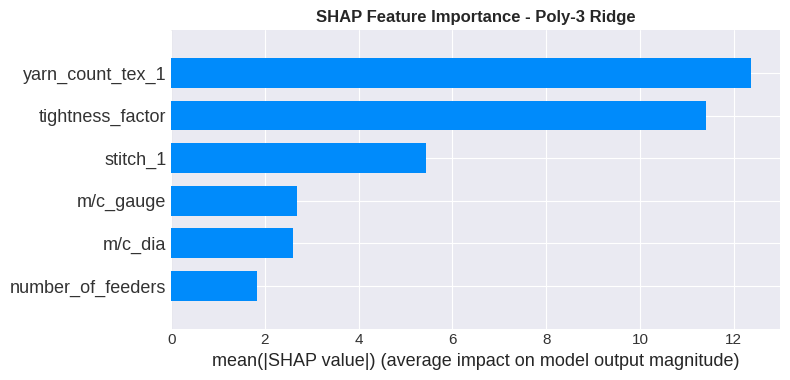

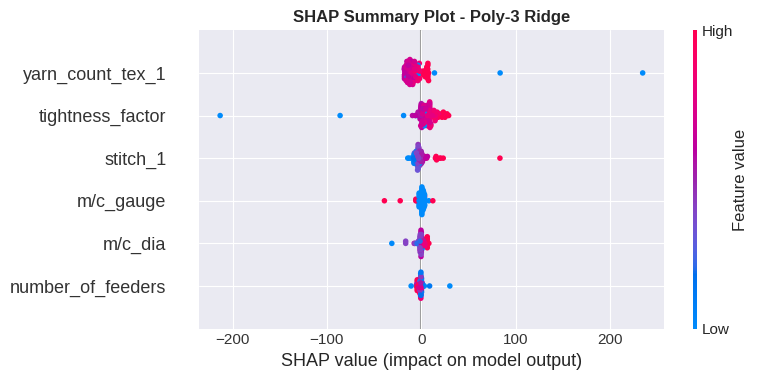


 SHAP plots saved for Poly-3 Ridge

SHAP Analysis: Best Black-Box (Extra Trees)


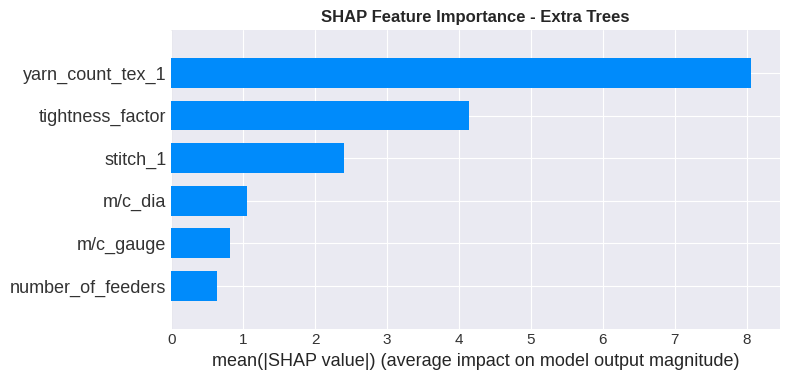

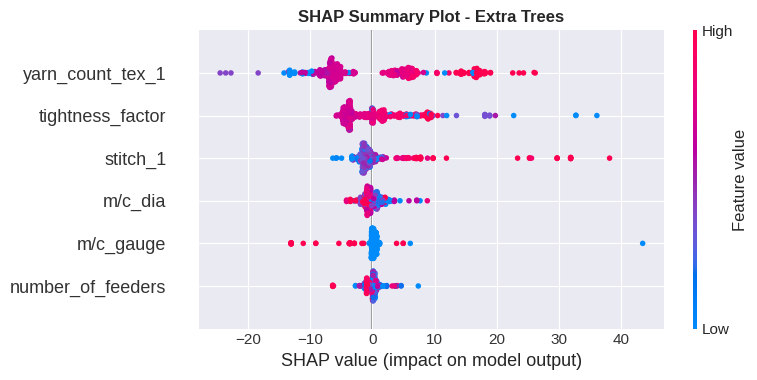


 SHAP plots saved for Extra Trees


In [35]:
if SHAP_AVAILABLE:
    # Analyze best interpretable and best black-box models
    models_to_analyze = {
        'Best Interpretable': best_interp['Model'],
        'Best Black-Box': best_blackbox['Model']
    }

    for model_label, model_name in models_to_analyze.items():
        print(f"\n{'='*80}")
        print(f"SHAP Analysis: {model_label} ({model_name})")
        print(f"{'='*80}")

        model, model_type = trained_models[model_name]


        if any(x in model_name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB']):
            explainer = shap.TreeExplainer(model)
            X_sample = X_test[:500] if len(X_test) > 500 else X_test
            shap_values = explainer.shap_values(X_sample)
        else:

            X_background = shap.sample(X_train_scaled, 100)
            explainer = shap.KernelExplainer(model.predict, X_background)
            X_sample = X_test_scaled[:100]
            shap_values = explainer.shap_values(X_sample)

        # Summary plot (bar)
        fig, ax = plt.subplots(figsize=(10, 6))
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names,
                         plot_type='bar', show=False)
        plt.title(f'SHAP Feature Importance - {model_name}', fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'shap_importance_{model_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Summary plot (beeswarm)
        fig, ax = plt.subplots(figsize=(10, 6))
        shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False)
        plt.title(f'SHAP Summary Plot - {model_name}', fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'shap_summary_{model_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
        plt.show()

        print(f"\n SHAP plots saved for {model_name}")
else:
    print("  SHAP not available. Install with: pip install shap")

### SHAP - Global Feature Importance

In [36]:
import numpy as np
import pandas as pd


# Handle TreeExplainer vs KernelExplainer output
if isinstance(shap_values, list):
    shap_array = shap_values[0]
else:
    shap_array = shap_values.values if hasattr(shap_values, 'values') else shap_values

mean_shap = np.abs(shap_array).mean(axis=0)
percentage = (mean_shap / mean_shap.sum()) * 100

shap_summary_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean SHAP Value (g/m²)': mean_shap,
    'Percentage Contribution (%)': percentage
})

shap_summary_df = shap_summary_df.sort_values(
    'Percentage Contribution (%)',
    ascending=False
).reset_index(drop=True)

shap_summary_df.insert(0, 'Rank', shap_summary_df.index + 1)

shap_summary_df


Rank            Feature  Mean SHAP Value (g/m²)  \
0     1   yarn_count_tex_1                8.059168   
1     2   tightness_factor                4.143077   
2     3           stitch_1                2.402429   
3     4            m/c_dia                1.048524   
4     5          m/c_gauge                0.815527   
5     6  number_of_feeders                0.630227   

   Percentage Contribution (%)  
0                    47.132529  
1                    24.230006  
2                    14.050152  
3                     6.132097  
4                     4.769454  
5                     3.685762

### SHAP - Individual Predictions (Waterfall Plots)


Waterfall plots for: Poly-3 Ridge


  0%|          | 0/100 [00:00<?, ?it/s]

 Saved: waterfall_Poly-3_Ridge_Low_GSM_sample93.png


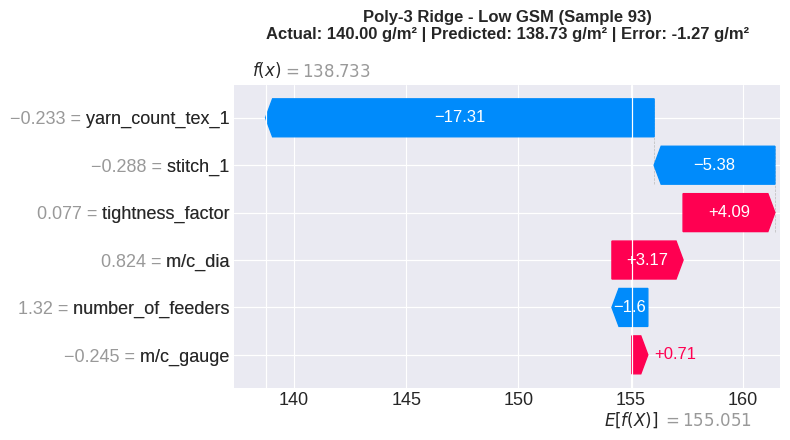

 Saved: waterfall_Poly-3_Ridge_Medium_GSM_sample53.png


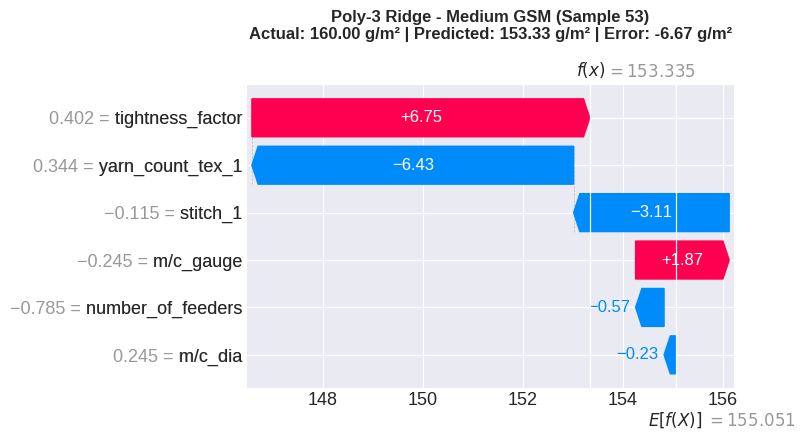

 Saved: waterfall_Poly-3_Ridge_High_GSM_sample13.png


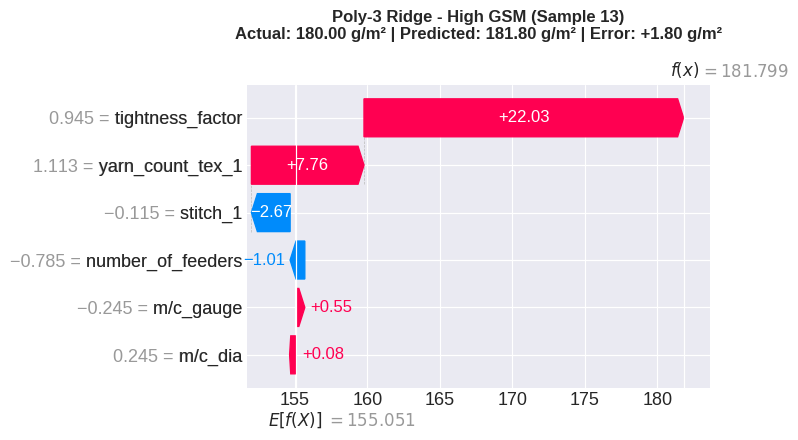


Sample   Actual GSM   Predicted GSM   Error     
--------------------------------------------------
93       140.00       138.73               -1.27
53       160.00       153.33               -6.67
13       180.00       181.80               +1.80

Waterfall plots for: Extra Trees
 Saved: waterfall_Extra_Trees_Low_GSM_sample45.png


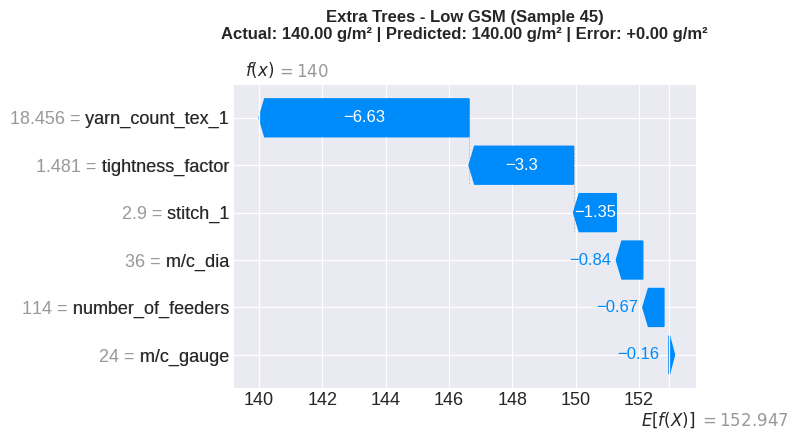

 Saved: waterfall_Extra_Trees_Medium_GSM_sample7.png


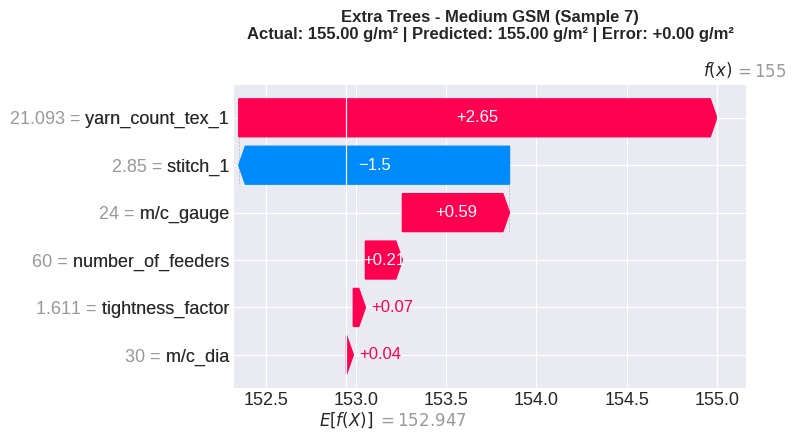

 Saved: waterfall_Extra_Trees_High_GSM_sample42.png


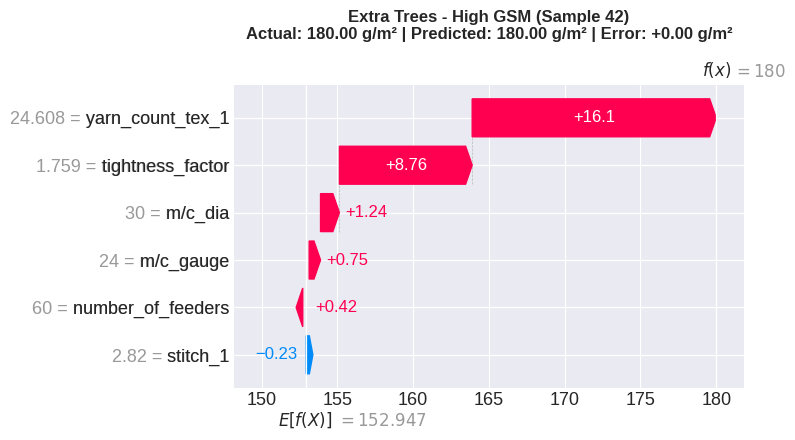


Sample   Actual GSM   Predicted GSM   Error     
--------------------------------------------------
45       140.00       140.00               +0.00
7        155.00       155.00               +0.00
42       180.00       180.00               +0.00


In [37]:
if SHAP_AVAILABLE:
    # SHAP waterfall plots for 3 specific samples
    for model_label, model_name in models_to_analyze.items():
        print(f"\n{'='*60}")
        print(f"Waterfall plots for: {model_name}")
        print(f"{'='*60}")

        model, model_type = trained_models[model_name]


        try:
            if any(x in model_name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB']):
                explainer = shap.TreeExplainer(model)
                X_sample = X_test.iloc[:100] if hasattr(X_test, 'iloc') else X_test[:100]
                shap_values = explainer(X_sample)
            else:

                X_background = shap.sample(X_train_scaled, 100)
                explainer = shap.KernelExplainer(model.predict, X_background)
                X_sample = X_test_scaled[:100]
                shap_values = explainer.shap_values(X_sample)

            # 3 diverse samples (low, medium, high GSM predictions)
            predictions = model.predict(X_sample if 'Tree' in model_name else X_sample)


            sorted_indices = np.argsort(predictions)
            low_idx = sorted_indices[10]
            mid_idx = sorted_indices[len(sorted_indices)//2]  # median
            high_idx = sorted_indices[-10]

            sample_indices = [low_idx, mid_idx, high_idx]
            sample_labels = ['Low GSM', 'Medium GSM', 'High GSM']


            for plot_idx, (sample_idx, label) in enumerate(zip(sample_indices, sample_labels)):

                actual_gsm = y_test.iloc[sample_idx] if hasattr(y_test, 'iloc') else y_test[sample_idx]
                pred_gsm = predictions[sample_idx]
                error = pred_gsm - actual_gsm


                plt.figure(figsize=(10, 6))

                if hasattr(shap_values, 'values'):

                    shap.waterfall_plot(
                        shap.Explanation(
                            values=shap_values.values[sample_idx],
                            base_values=shap_values.base_values[sample_idx],
                            data=X_sample.iloc[sample_idx] if hasattr(X_sample, 'iloc') else X_sample[sample_idx],
                            feature_names=feature_names
                        ),
                        max_display=10,
                        show=False
                    )
                else:

                    shap.waterfall_plot(
                        shap.Explanation(
                            values=shap_values[sample_idx],
                            base_values=explainer.expected_value,
                            data=X_sample[sample_idx],
                            feature_names=feature_names
                        ),
                        max_display=10,
                        show=False
                    )


                plt.title(
                    f'{model_name} - {label} (Sample {sample_idx})\n'
                    f'Actual: {actual_gsm:.2f} g/m² | Predicted: {pred_gsm:.2f} g/m² | Error: {error:+.2f} g/m²',
                    fontsize=12,
                    fontweight='bold',
                    pad=15
                )

                plt.tight_layout()


                filename = f'waterfall_{model_name.replace(" ", "_")}_{label.replace(" ", "_")}_sample{sample_idx}.png'
                plt.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
                print(f" Saved: {filename}")
                plt.show()
                plt.close()


            print(f"\n{'Sample':<8} {'Actual GSM':<12} {'Predicted GSM':<15} {'Error':<10}")
            print(f"{'-'*50}")
            for idx, sample_idx in enumerate(sample_indices):
                actual = y_test.iloc[sample_idx] if hasattr(y_test, 'iloc') else y_test[sample_idx]
                pred = predictions[sample_idx]
                print(f"{sample_idx:<8} {actual:<12.2f} {pred:<15.2f} {pred-actual:+10.2f}")

        except Exception as e:
            print(f" Error generating waterfall plots for {model_name}: {str(e)}")
            import traceback
            traceback.print_exc()

else:
    print("  SHAP not available - install with: pip install shap")

##  Interpretability Analysis - LIME

LIME - Local Interpretable Model-Agnostic Explanations


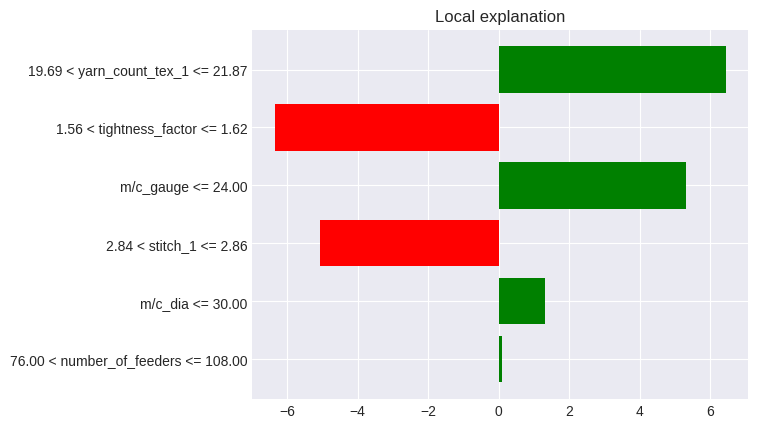

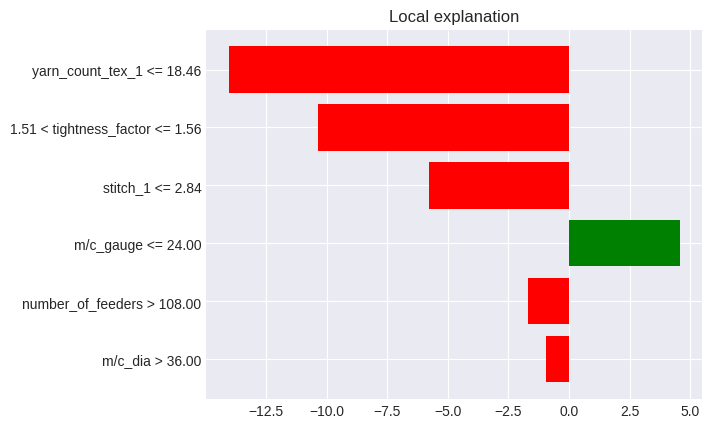

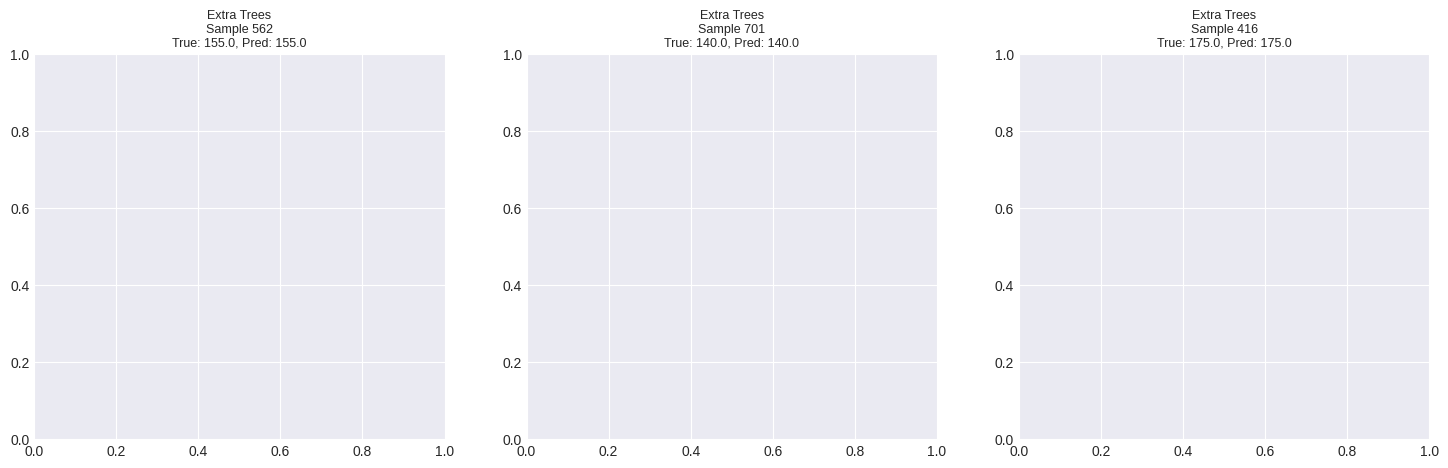

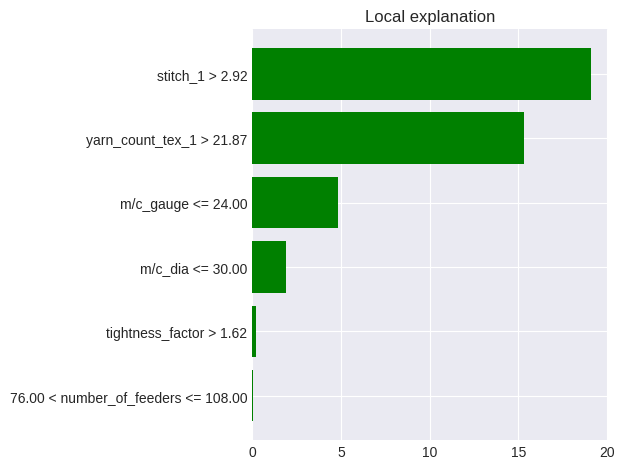


 LIME explanations generated for Extra Trees


In [38]:
!pip install lime -qq

try:
    import lime
    import lime.lime_tabular
    LIME_AVAILABLE = True
except:
    LIME_AVAILABLE = False

if LIME_AVAILABLE:
    print("="*80)
    print("LIME - Local Interpretable Model-Agnostic Explanations")
    print("="*80)

    # Create LIME explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train,
        feature_names=feature_names,
        mode='regression',
        random_state=RANDOM_STATE
    )

    # Explain predictions from best black-box model
    model_name = best_blackbox['Model']
    model, _ = trained_models[model_name]

    # Select 3 test samples
    sample_indices = np.random.choice(len(X_test), 3, replace=False)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, sample_idx in enumerate(sample_indices):

        if any(x in model_name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB']):
            exp = lime_explainer.explain_instance(X_test[sample_idx], model.predict, num_features=6)
        else:
            exp = lime_explainer.explain_instance(X_test_scaled[sample_idx], model.predict, num_features=6)

        # Plot
        plt.sca(axes[idx])
        exp.as_pyplot_figure()
        axes[idx].set_title(f'{model_name}\nSample {sample_idx}\nTrue: {y_test[sample_idx]:.1f}, Pred: {model.predict([X_test[sample_idx]])[0]:.1f}',
                           fontsize=9)


    plt.tight_layout()
    plt.savefig('lime_explanations.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n LIME explanations generated for {model_name}")
else:
    print("  LIME not available. Install with: pip install lime")

In [39]:
import lime
import lime.lime_tabular


lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_scaled,
    feature_names=feature_names,
    mode='regression',
    verbose=False
)


model = trained_models['Extra Trees'][0]

sample_idx = 50
explanation = lime_explainer.explain_instance(
    X_test_scaled[sample_idx],
    model.predict,
    num_features=6
)


print("Actual feature values for this sample:")
if hasattr(X_test, 'iloc'):

    for i, feat in enumerate(feature_names):
        print(f"{feat}: {X_test.iloc[sample_idx][feat]:.3f}")
    actual_gsm = y_test.iloc[sample_idx]
else:

    for i, feat in enumerate(feature_names):
        print(f"{feat}: {X_test[sample_idx, i]:.3f}")
    actual_gsm = y_test[sample_idx]

pred_gsm = model.predict(X_test_scaled[sample_idx].reshape(1, -1))[0]
print(f"\nActual GSM: {actual_gsm:.2f}")
print(f"Predicted GSM: {pred_gsm:.2f}")
print(f"Error: {pred_gsm - actual_gsm:+.2f}")

# Show LIME explanation
explanation.show_in_notebook()


print("\n" + "="*60)
print("Correlation Analysis: Data vs GSM")
print("="*60)


feature_dict = {name: idx for idx, name in enumerate(feature_names)}

# Checking correlation in test set
key_features = ['tightness_factor', 'yarn_count_tex_1', 'stitch_1', 'm/c_gauge', 'm/c_dia']

for feat in key_features:
    feat_idx = feature_dict[feat]


    if hasattr(X_test, 'iloc'):
        feat_values = X_test[feat].values
        actual_y = y_test.values
    else:
        feat_values = X_test[:, feat_idx]
        actual_y = y_test

    corr_actual = np.corrcoef(feat_values, actual_y)[0, 1]

    # Correlation with predicted GSM
    preds = model.predict(X_test_scaled)
    corr_pred = np.corrcoef(feat_values, preds)[0, 1]


    expected_sign = "+" if feat in ['tightness_factor', 'yarn_count_tex_1', 'stitch_1'] else "+/-"
    match = "✓" if (corr_actual > 0 and corr_pred > 0 and feat in ['tightness_factor', 'yarn_count_tex_1', 'stitch_1']) else "⚠️"

    print(f"{feat:20s} | Actual: {corr_actual:+.3f} | Predicted: {corr_pred:+.3f} | {match}")

print("\n" + "="*60)
print("LIME vs SHAP Comparison")
print("="*60)


lime_weights = dict(explanation.as_list())
print("\nLIME Feature Contributions (for this sample):")
for feat, weight in sorted(lime_weights.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"  {feat:40s}: {weight:+8.3f} g/m²")


if SHAP_AVAILABLE:
    print("\n" + "="*60)
    print("SHAP Analysis for the Same Sample")
    print("="*60)

    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X_test[:100])

        print(f"\nSHAP Feature Contributions (Sample {sample_idx}):")
        shap_vals = shap_values.values[sample_idx]

        for i, (feat, val) in enumerate(zip(feature_names, shap_vals)):
            print(f"  {feat:20s}: {val:+8.3f} g/m²")

        print("\n" + "="*60)
        print("Key Insight:")
        print("="*60)
        tightness_shap = shap_vals[feature_dict['tightness_factor']]
        print(f"SHAP says tightness_factor contributes: {tightness_shap:+.2f} g/m²")


        for lime_feat, lime_val in lime_weights.items():
            if 'tightness_factor' in lime_feat:
                print(f"LIME says tightness_factor contributes: {lime_val:+.2f} g/m²")
                if (tightness_shap > 0 and lime_val < 0) or (tightness_shap < 0 and lime_val > 0):
                    print("  WARNING: LIME and SHAP have OPPOSITE signs for tightness_factor!")
                else:
                    print(" LIME and SHAP agree on the direction")
                break
    except Exception as e:
        print(f"Could not compute SHAP: {e}")

Actual feature values for this sample:
yarn_count_tex_1: 3.333
stitch_1: 3.100
tightness_factor: 0.589
m/c_dia: 28.000
m/c_gauge: 28.000
number_of_feeders: 56.000

Actual GSM: 160.00
Predicted GSM: 205.09
Error: +45.09



Correlation Analysis: Data vs GSM
tightness_factor     | Actual: +0.151 | Predicted: +0.337 | ✓
yarn_count_tex_1     | Actual: +0.343 | Predicted: +0.403 | ✓
stitch_1             | Actual: +0.458 | Predicted: -0.033 | ⚠️
m/c_gauge            | Actual: -0.160 | Predicted: -0.088 | ⚠️
m/c_dia              | Actual: -0.187 | Predicted: -0.192 | ⚠️

LIME vs SHAP Comparison

LIME Feature Contributions (for this sample):
  stitch_1 > 0.13                         :   +5.882 g/m²
  tightness_factor <= -0.04               :   -1.227 g/m²
  yarn_count_tex_1 <= -0.23               :   -0.246 g/m²
  m/c_gauge > -0.24                       :   +0.152 g/m²
  number_of_feeders <= -0.79              :   +0.121 g/m²
  m/c_dia <= -0.91                        :   +0.035 g/m²

SHAP Analysis for the Same Sample

SHAP Feature Contributions (Sample 50):
  yarn_count_tex_1    :   -3.814 g/m²
  stitch_1            :   +6.791 g/m²
  tightness_factor    :  +11.945 g/m²
  m/c_dia             :   -2.866 g/m²
  m/

###  Tree-Based Feature Importance

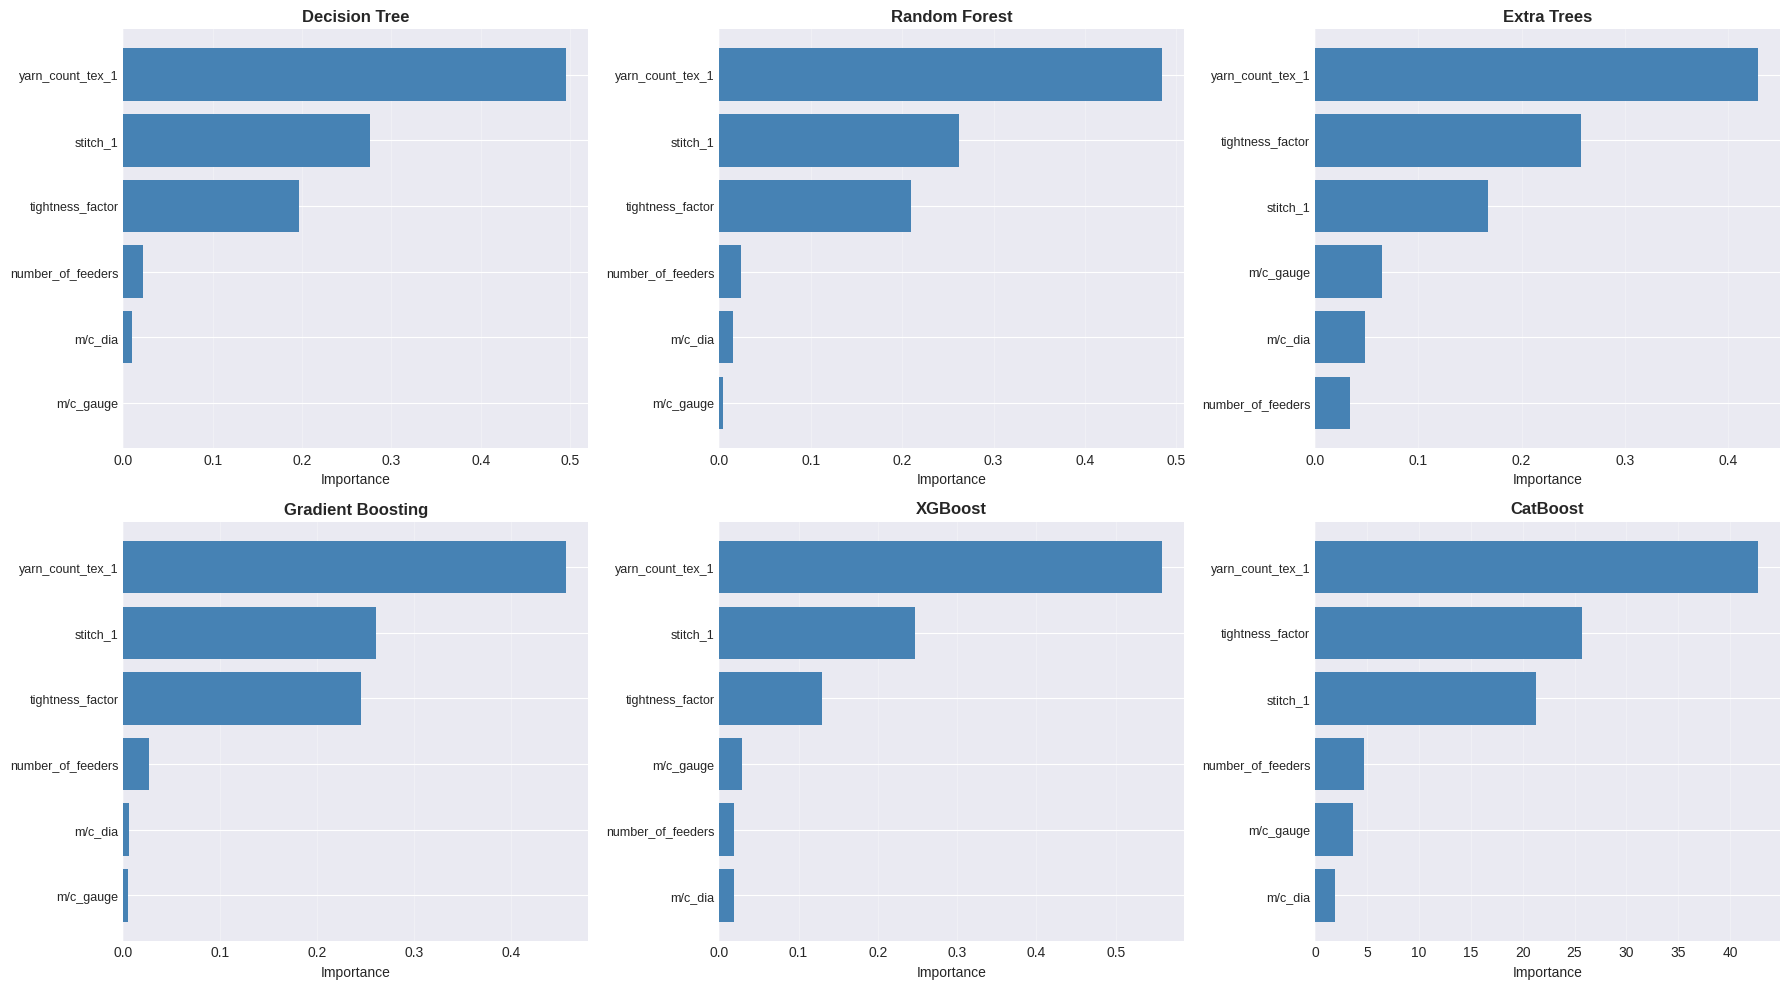


 Tree-based feature importances plotted


In [40]:
# Compare feature importance across tree-based models
tree_models = {name: (model, mtype) for name, (model, mtype) in trained_models.items()
               if any(x in name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB'])}

if tree_models:
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    for idx, (model_name, (model, _)) in enumerate(list(tree_models.items())[:6]):
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]

            axes[idx].barh(range(len(feature_names)), importances[indices], color='steelblue')
            axes[idx].set_yticks(range(len(feature_names)))
            axes[idx].set_yticklabels([feature_names[i] for i in indices], fontsize=9)
            axes[idx].set_xlabel('Importance')
            axes[idx].set_title(model_name, fontweight='bold')
            axes[idx].invert_yaxis()
            axes[idx].grid(axis='x', alpha=0.3)


    for idx in range(len(tree_models), 6):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.savefig('feature_importance_trees.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n Tree-based feature importances plotted")
else:
    print("No tree-based models available")

###  Linear Model Coefficients

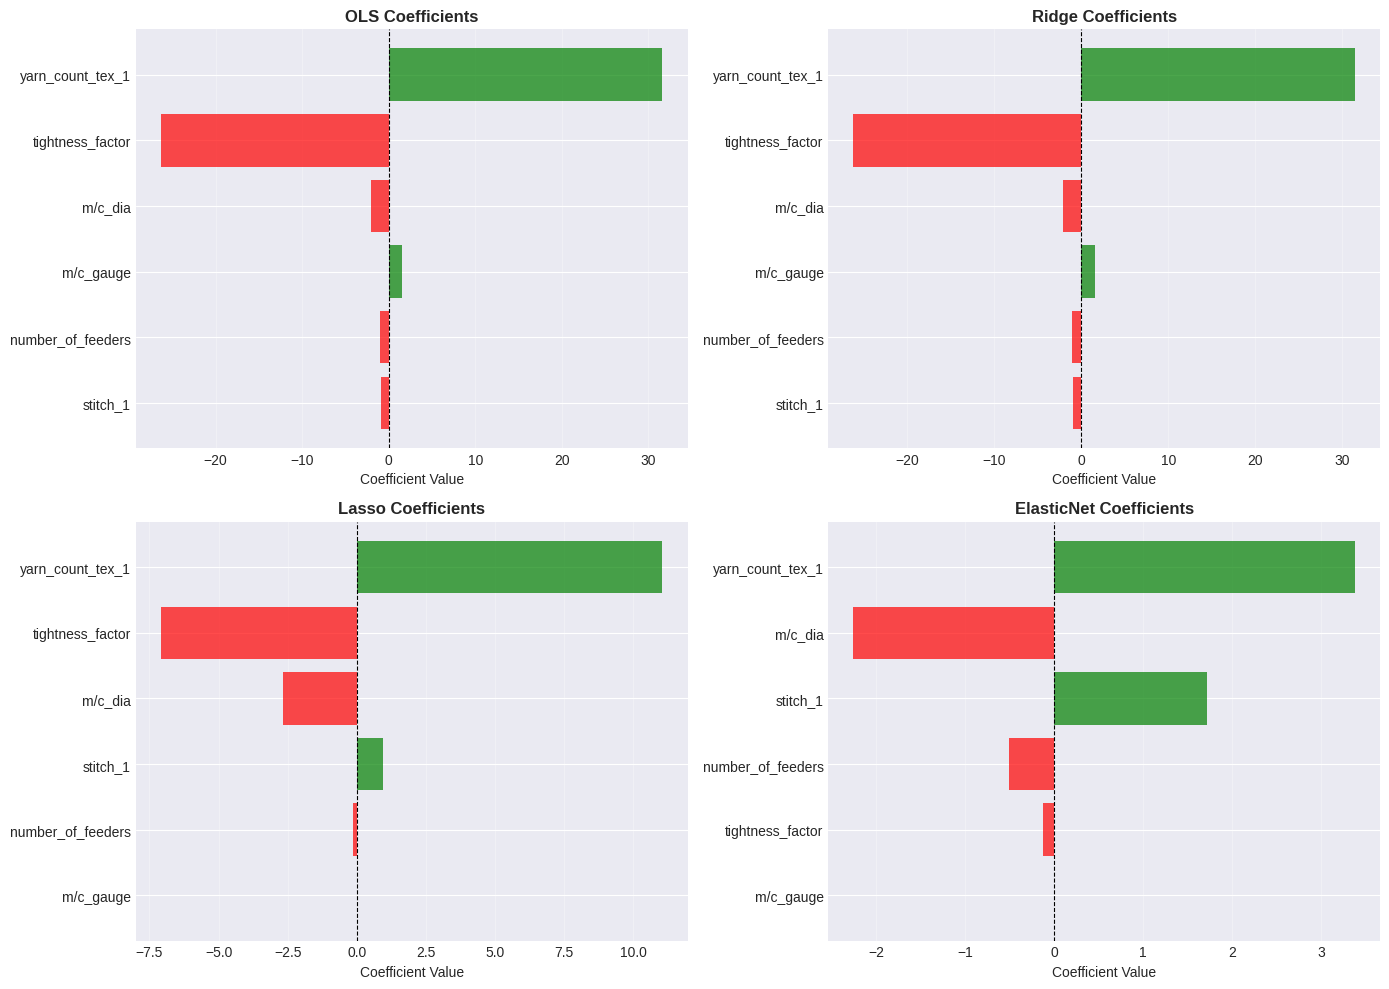


 Linear model coefficients plotted

 Coefficient Interpretation:
   Green bars: Positive relationship with GSM (↑ feature → ↑ GSM)
   Red bars: Negative relationship with GSM (↑ feature → ↓ GSM)


In [41]:
# Show coefficients for interpretable linear models
linear_models = {name: (model, mtype) for name, (model, mtype) in trained_models.items()
                 if name in ['OLS', 'Ridge', 'Lasso', 'ElasticNet']}

if linear_models:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, (model_name, (model, _)) in enumerate(linear_models.items()):
        if hasattr(model, 'coef_'):
            coefs = model.coef_
            indices = np.argsort(np.abs(coefs))[::-1]

            colors = ['green' if c > 0 else 'red' for c in coefs[indices]]
            axes[idx].barh(range(len(feature_names)), coefs[indices], color=colors, alpha=0.7)
            axes[idx].set_yticks(range(len(feature_names)))
            axes[idx].set_yticklabels([feature_names[i] for i in indices])
            axes[idx].set_xlabel('Coefficient Value')
            axes[idx].set_title(f'{model_name} Coefficients', fontweight='bold')
            axes[idx].invert_yaxis()
            axes[idx].axvline(0, color='black', linestyle='--', linewidth=0.8)
            axes[idx].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('feature_coefficients_linear.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n Linear model coefficients plotted")
    print("\n Coefficient Interpretation:")
    print("   Green bars: Positive relationship with GSM (↑ feature → ↑ GSM)")
    print("   Red bars: Negative relationship with GSM (↑ feature → ↓ GSM)")

##  Partial Dependence Plots

Generating Partial Dependence Plots for: ElasticNet


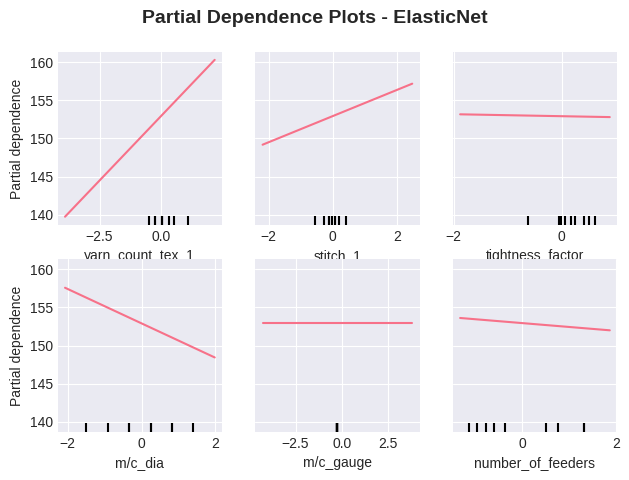


 Partial dependence plots created

 Interpretation: Shows how GSM changes as each feature varies (holding others constant)


In [42]:

from sklearn.inspection import PartialDependenceDisplay

print(f"Generating Partial Dependence Plots for: {model_name}")


if any(x in model_name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB']):
    X_pd = X_test
else:
    X_pd = X_test_scaled


display = PartialDependenceDisplay.from_estimator(
    model,
    X_pd,
    features=list(range(len(feature_names))),
    feature_names=feature_names,
    kind='average',
    n_cols=3
)

plt.suptitle(f'Partial Dependence Plots - {model_name}',
            fontsize=14, fontweight='bold', y=0.99)
plt.tight_layout()
plt.savefig('partial_dependence.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Partial dependence plots created")
print("\n Interpretation: Shows how GSM changes as each feature varies (holding others constant)")

##  Residual Analysis

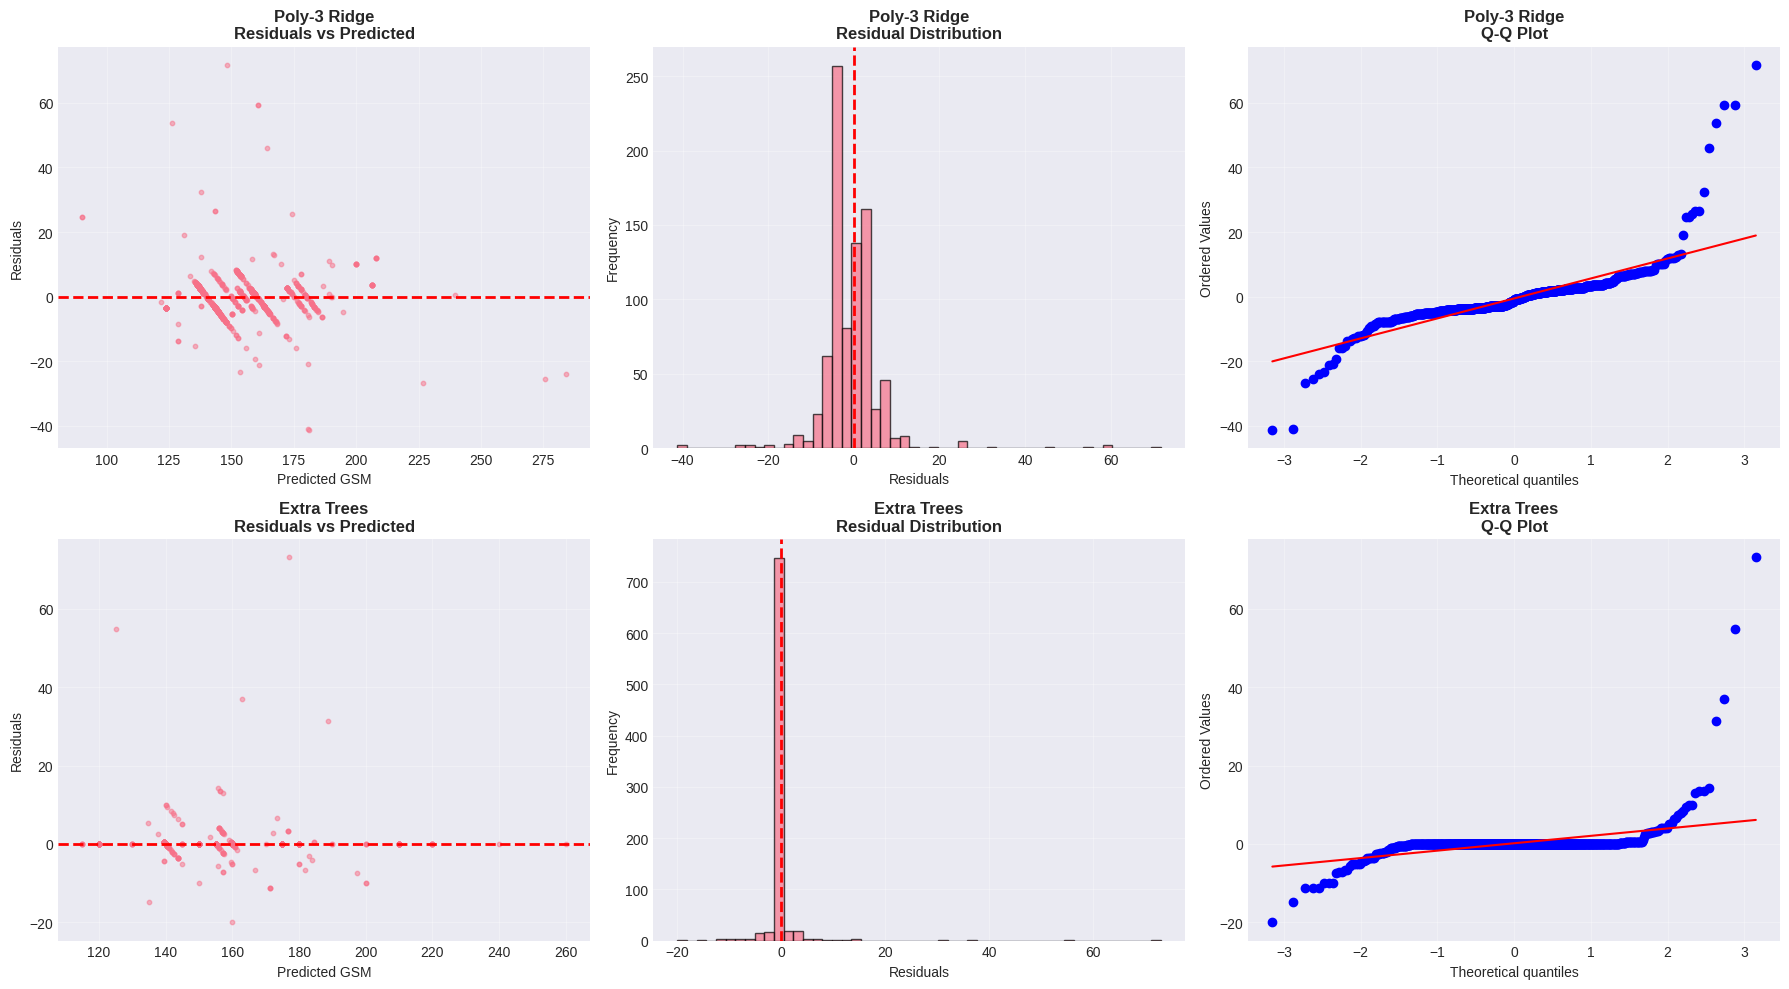


 Residual analysis complete

 What to look for:
   - Random scatter around zero = good (no systematic bias)
   - Normal distribution = model assumptions satisfied
   - Q-Q plot follows line = residuals are normally distributed


In [43]:
# Residual analysis for best interpretable and best black-box
models_to_analyze = {
    best_interp['Model']: 'Interpretable',
    best_blackbox['Model']: 'Black-Box'
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for row, (model_name, model_type) in enumerate(models_to_analyze.items()):
    model, _ = trained_models[model_name]


    if any(x in model_name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB']):
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test_scaled)

    residuals = y_test - y_pred

    #  Residuals vs Predicted
    axes[row, 0].scatter(y_pred, residuals, alpha=0.5, s=10)
    axes[row, 0].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[row, 0].set_xlabel('Predicted GSM')
    axes[row, 0].set_ylabel('Residuals')
    axes[row, 0].set_title(f'{model_name}\nResiduals vs Predicted', fontweight='bold')
    axes[row, 0].grid(alpha=0.3)

    #  Histogram of residuals
    axes[row, 1].hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    axes[row, 1].axvline(0, color='red', linestyle='--', linewidth=2)
    axes[row, 1].set_xlabel('Residuals')
    axes[row, 1].set_ylabel('Frequency')
    axes[row, 1].set_title(f'{model_name}\nResidual Distribution', fontweight='bold')
    axes[row, 1].grid(alpha=0.3)

    #  Q-Q plot
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[row, 2])
    axes[row, 2].set_title(f'{model_name}\nQ-Q Plot', fontweight='bold')
    axes[row, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('residual_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Residual analysis complete")
print("\n What to look for:")
print("   - Random scatter around zero = good (no systematic bias)")
print("   - Normal distribution = model assumptions satisfied")
print("   - Q-Q plot follows line = residuals are normally distributed")

### Residuals by Feature Values

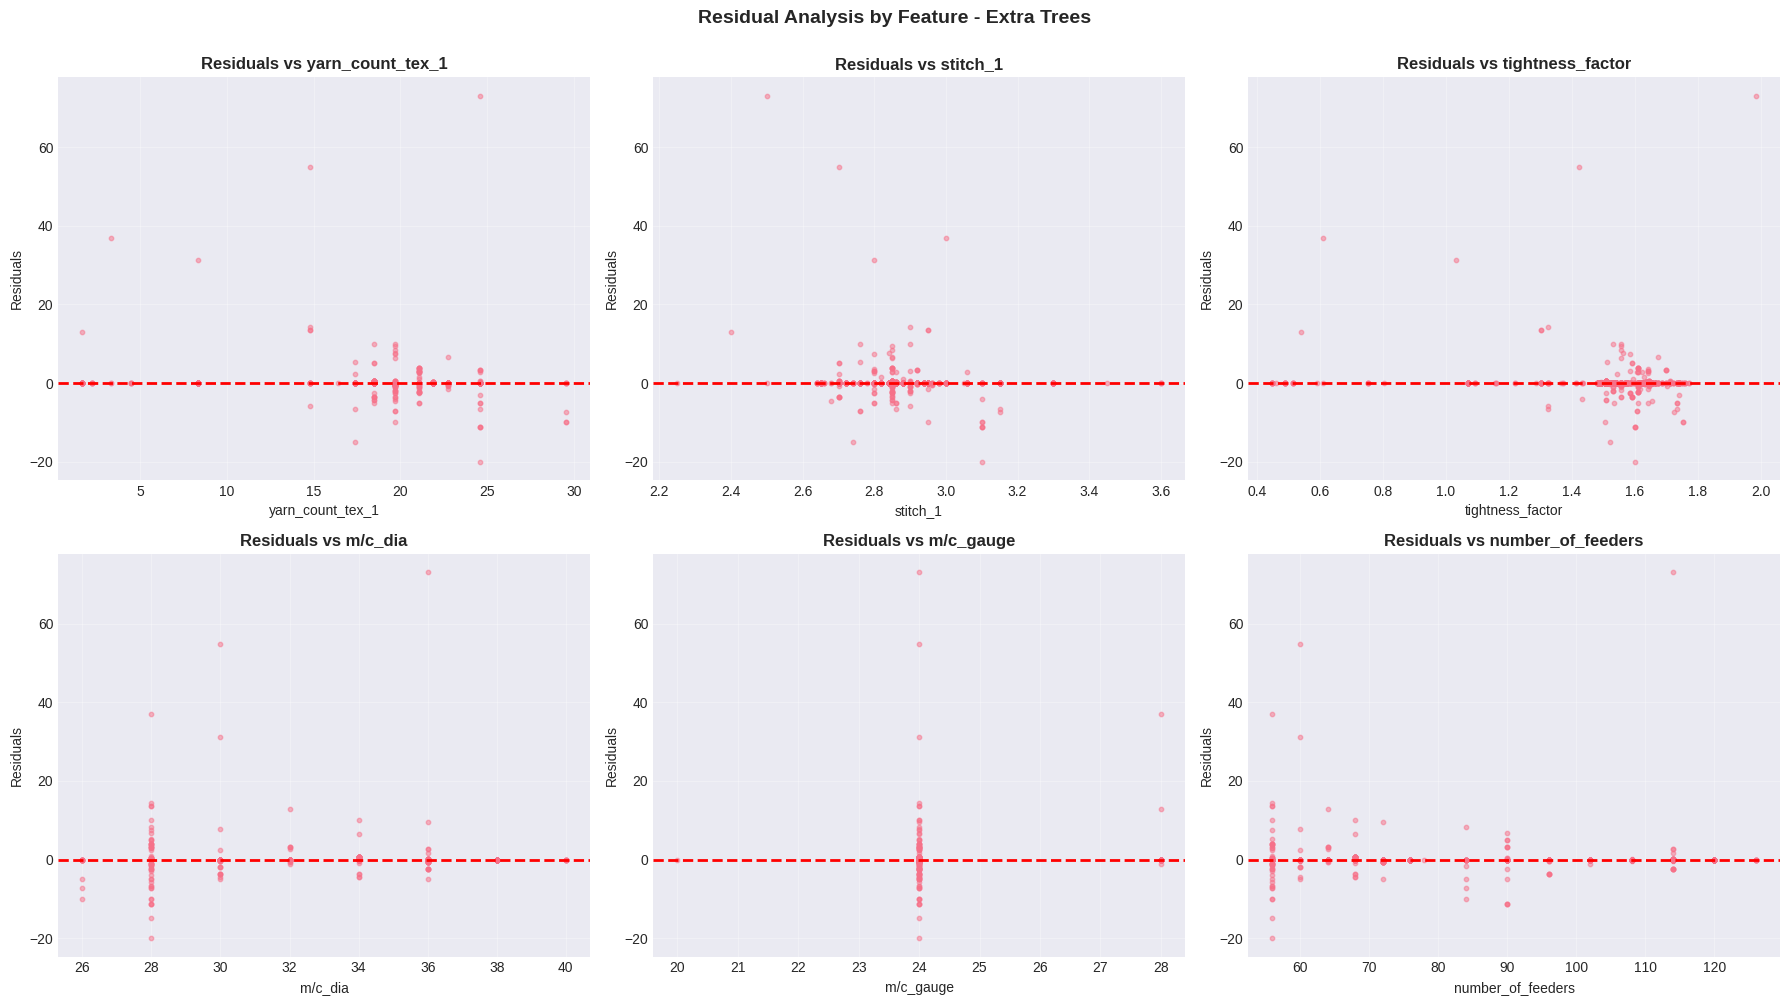


 Residuals by feature plotted

 Look for systematic patterns:
   - Funnel shape = heteroscedasticity (variance changes)
   - Curve pattern = non-linear relationship not captured


In [44]:
# Analyze residuals across feature ranges
model_name = best_overall['Model']
model, _ = trained_models[model_name]

if any(x in model_name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB']):
    y_pred = model.predict(X_test)
else:
    y_pred = model.predict(X_test_scaled)

residuals = y_test - y_pred

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature_idx in enumerate(range(len(feature_names))):
    axes[idx].scatter(X_test[:, feature_idx], residuals, alpha=0.5, s=10)
    axes[idx].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[idx].set_xlabel(feature_names[feature_idx])
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'Residuals vs {feature_names[feature_idx]}', fontweight='bold')
    axes[idx].grid(alpha=0.3)

plt.suptitle(f'Residual Analysis by Feature - {model_name}', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('residuals_by_feature.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Residuals by feature plotted")
print("\n Look for systematic patterns:")
print("   - Funnel shape = heteroscedasticity (variance changes)")
print("   - Curve pattern = non-linear relationship not captured")

###  Predicted vs Actual GSM

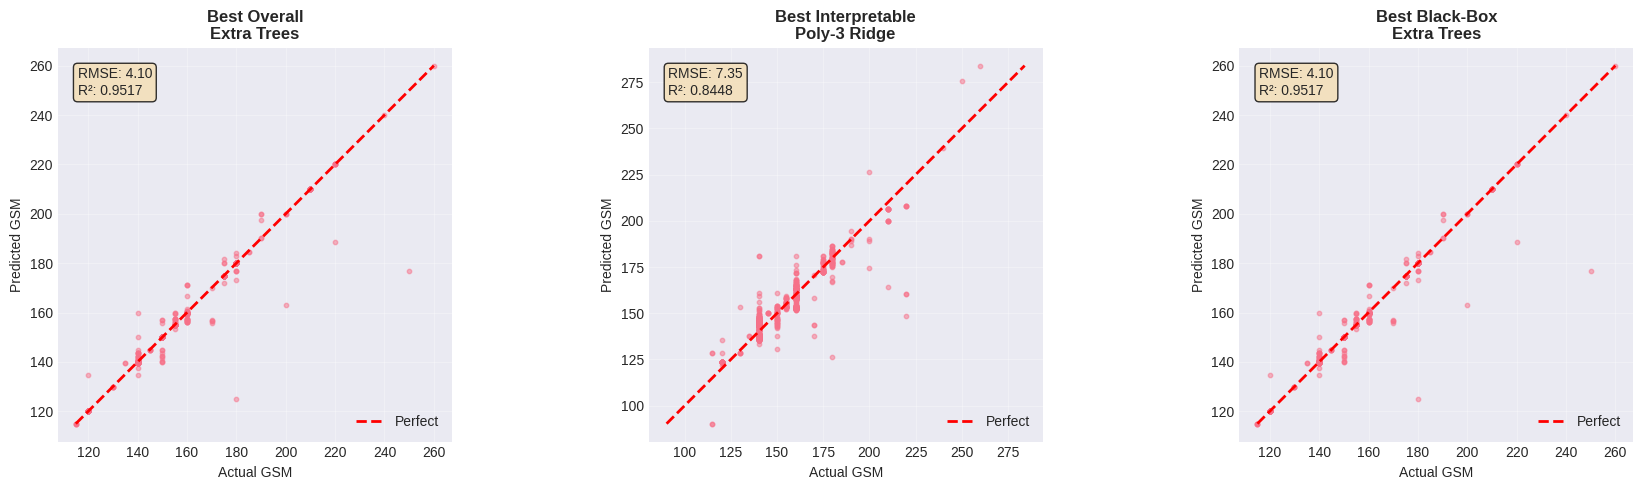


 Predicted vs Actual plots created


In [45]:
# Compare predictions to actual for best models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_to_plot = [
    (best_overall['Model'], 'Best Overall'),
    (best_interp['Model'], 'Best Interpretable'),
    (best_blackbox['Model'], 'Best Black-Box')
]

for idx, (model_name, label) in enumerate(models_to_plot):
    model, _ = trained_models[model_name]

    if any(x in model_name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB']):
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test_scaled)


    axes[idx].scatter(y_test, y_pred, alpha=0.5, s=10)


    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect')


    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    axes[idx].text(0.05, 0.95, f'RMSE: {rmse:.2f}\nR²: {r2:.4f}',
                  transform=axes[idx].transAxes, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                  fontsize=10)

    axes[idx].set_xlabel('Actual GSM')
    axes[idx].set_ylabel('Predicted GSM')
    axes[idx].set_title(f'{label}\n{model_name}', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    axes[idx].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig('predicted_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Predicted vs Actual plots created")

###  Physics Relationships - Model Learns Correct Patterns?

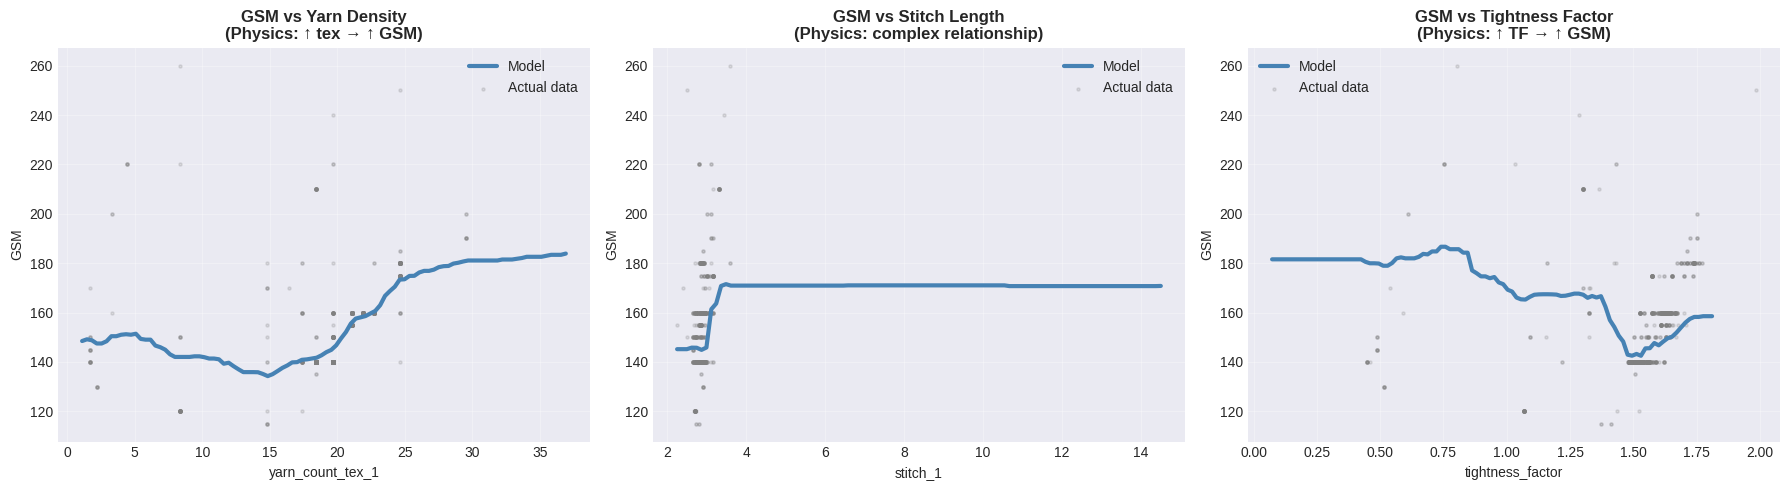


 Physics validation plots created

 Expected Physics Relationships:
   - Higher yarn density (tex_1) → Higher GSM (more material)
   - Stitch length: Complex relationship (affects fabric structure)
   - Higher tightness factor → Higher GSM (tighter knit)

   Model should capture these known textile physics relationships!


In [46]:

model_name = best_overall['Model']
model, _ = trained_models[model_name]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Feature indices
tex_idx = feature_names.index('yarn_count_tex_1')
stitch_idx = feature_names.index('stitch_1')
tf_idx = feature_names.index('tightness_factor')


base_point = np.median(X_train, axis=0)

#  GSM vs yarn_count_tex_1
tex_range = np.linspace(X_train[:, tex_idx].min(), X_train[:, tex_idx].max(), 100)
X_synth = np.tile(base_point, (100, 1))
X_synth[:, tex_idx] = tex_range

if any(x in model_name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB']):
    y_synth = model.predict(X_synth)
else:
    y_synth = model.predict(scaler.transform(X_synth))

axes[0].plot(tex_range, y_synth, linewidth=3, color='steelblue', label='Model')
axes[0].scatter(X_test[:, tex_idx], y_test, alpha=0.2, s=5, color='gray', label='Actual data')
axes[0].set_xlabel('yarn_count_tex_1')
axes[0].set_ylabel('GSM')
axes[0].set_title('GSM vs Yarn Density\n(Physics: ↑ tex → ↑ GSM)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

#  GSM vs stitch_1
stitch_range = np.linspace(X_train[:, stitch_idx].min(), X_train[:, stitch_idx].max(), 100)
X_synth = np.tile(base_point, (100, 1))
X_synth[:, stitch_idx] = stitch_range

if any(x in model_name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB']):
    y_synth = model.predict(X_synth)
else:
    y_synth = model.predict(scaler.transform(X_synth))

axes[1].plot(stitch_range, y_synth, linewidth=3, color='steelblue', label='Model')
axes[1].scatter(X_test[:, stitch_idx], y_test, alpha=0.2, s=5, color='gray', label='Actual data')
axes[1].set_xlabel('stitch_1')
axes[1].set_ylabel('GSM')
axes[1].set_title('GSM vs Stitch Length\n(Physics: complex relationship)', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

#  GSM vs tightness_factor
tf_range = np.linspace(X_train[:, tf_idx].min(), X_train[:, tf_idx].max(), 100)
X_synth = np.tile(base_point, (100, 1))
X_synth[:, tf_idx] = tf_range

if any(x in model_name for x in ['Tree', 'Forest', 'Boosting', 'XGB', 'LGB', 'CatB']):
    y_synth = model.predict(X_synth)
else:
    y_synth = model.predict(scaler.transform(X_synth))

axes[2].plot(tf_range, y_synth, linewidth=3, color='steelblue', label='Model')
axes[2].scatter(X_test[:, tf_idx], y_test, alpha=0.2, s=5, color='gray', label='Actual data')
axes[2].set_xlabel('tightness_factor')
axes[2].set_ylabel('GSM')
axes[2].set_title('GSM vs Tightness Factor\n(Physics: ↑ TF → ↑ GSM)', fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('physics_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Physics validation plots created")
print("\n Expected Physics Relationships:")
print("   - Higher yarn density (tex_1) → Higher GSM (more material)")
print("   - Stitch length: Complex relationship (affects fabric structure)")
print("   - Higher tightness factor → Higher GSM (tighter knit)")
print("\n   Model should capture these known textile physics relationships!")

##  Save Results

In [47]:
# Save results
results_df.to_csv('gsm_model_results_sj.csv', index=False)
print(" Saved: gsm_model_results_sj.csv")


print("\n" + "="*80)
print("EXPERIMENT COMPLETE")
print("="*80)
print(f"\nDataset: {len(df_clean):,} S/J samples")
print(f"Features: {len(feature_names)}")
print(f"Models Trained: {len(results_df)}")
print(f"\nBest Overall: {best_overall['Model']}")
print(f"  RMSE: {best_overall['Test_RMSE']:.2f}")
print(f"  R²: {best_overall['Test_R2']:.4f}")
print(f"  MAPE: {best_overall['Test_MAPE']:.2f}%")
print(f"\nBest Interpretable: {best_interp['Model']}")
print(f"  RMSE: {best_interp['Test_RMSE']:.2f}")
print(f"  Performance gap vs best: {(best_interp['Test_RMSE']-best_overall['Test_RMSE'])/best_overall['Test_RMSE']*100:.1f}%")
print(f"\nGenerated Visualizations:")
print(f"  - gsm_distribution_analysis.png")
print(f"  - feature_distributions.png")
print(f"  - physics_relationships.png")
print(f"  - correlation_matrix.png")
print(f"  - pairplot_top_features.png")
print(f"  - model_comparison.png")
if SHAP_AVAILABLE:
    print(f"  - shap_importance_*.png")
    print(f"  - shap_summary_*.png")
    print(f"  - shap_waterfall_*.png")
if LIME_AVAILABLE:
    print(f"  - lime_explanations.png")
print(f"  - feature_importance_trees.png")
print(f"  - feature_coefficients_linear.png")
print(f"  - partial_dependence.png")
print(f"  - residual_analysis.png")
print(f"  - residuals_by_feature.png")
print(f"  - predicted_vs_actual.png")
print(f"  - physics_validation.png")


 Saved: gsm_model_results_sj.csv

EXPERIMENT COMPLETE

Dataset: 5,648 S/J samples
Features: 6
Models Trained: 29

Best Overall: Extra Trees
  RMSE: 4.10
  R²: 0.9517
  MAPE: 0.47%

Best Interpretable: Poly-3 Ridge
  RMSE: 7.35
  Performance gap vs best: 79.3%

Generated Visualizations:
  - gsm_distribution_analysis.png
  - feature_distributions.png
  - physics_relationships.png
  - correlation_matrix.png
  - pairplot_top_features.png
  - model_comparison.png
  - shap_importance_*.png
  - shap_summary_*.png
  - shap_waterfall_*.png
  - lime_explanations.png
  - feature_importance_trees.png
  - feature_coefficients_linear.png
  - partial_dependence.png
  - residual_analysis.png
  - residuals_by_feature.png
  - predicted_vs_actual.png
  - physics_validation.png
